In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import struct
import sys
from array import array
import itertools
import os
import sys
from scipy import signal
from scipy.optimize import curve_fit
import subprocess
import shutil

pi = np.pi
clight = 299792458

In [3]:
working_folder = 'eSR/1RF_1type/Allow_thetaL/'
home = os.getcwd()
cwd = os.path.join(home,working_folder)

In [4]:
home

'/home/txin/Dropbox/code/Cpp/APES_pack/APES8.2'

In [5]:
inputfile = 'input0.txt'
inputfile = os.path.join(cwd,inputfile)
tempinput = {}
with open(inputfile) as inputfile:
    for line in inputfile:
        if len(line.split())>1:
            tempinput[line.split()[0]] = line.split()[1:]
for i in tempinput:
    for j in range(len(tempinput[i])):
        tempinput[i][j] = float(tempinput[i][j])

In [6]:
nRF = int(tempinput['nRF'][0])
nRF1 = int(tempinput['nRF1'][0])
nRF2 = int(tempinput['nRF2'][0])
nRFc = int(tempinput['nRFc'][0])

E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
nTurns = int(tempinput['n_turns'][0])
nfill = int(tempinput['n_fill'][0])
n_q_ramp = int(tempinput['n_q_ramp'][0])
NpRF = int(tempinput['N_bins'][0])
h = [int(i) for i in tempinput['h']]
detune_ini = np.array([i for i in tempinput['detune_ini']])
detune_final = np.array([i for i in tempinput['detune_final']])

step = int(tempinput['step_store'][0])
fill_step = int(tempinput['fill_step'][0])
nBeam = int(tempinput['nBeam'][0])
beam_shift = int(tempinput['beam_shift'][0])
nBunch = int(tempinput['n_bunches'][0])
nPar = int(tempinput['Npar'][0])
NperBunch = int(tempinput['NperBunch'][0])
nTot = nBunch*nPar*nBeam
Gamma0 = tempinput['Gamma'][0]
Rring = tempinput['R'][0]
n_record = nTurns/step
clight = 299792458
beta = np.sqrt(1-1/Gamma0**2)
T0 = 2*np.pi*Rring/(clight*beta)
f0 = 1/T0
V0 = [i for i in tempinput['Vref_I']]
V0Q = [i for i in tempinput['Vref_Q']]
II = [i for i in tempinput['Iref_I']]
IQ = [i for i in tempinput['Iref_Q']]
mainRF = int(tempinput['mainRF'][0])
if int(tempinput['type'][0]==2):
    atomicZ = 79
    Ek = Gamma0*E0Au
else:
    atomicZ =1
if int(tempinput['type'][0]==1):  
    Ek = Gamma0*E0Elec
    
GMTSQ = tempinput['GMTSQ'][0]
Ek_damp = tempinput['Ek_damp'][0]

eta = 1/GMTSQ-1/Gamma0**2
Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))

omegarf = 2*np.pi*(np.array(h)*f0)
omegac = 2*np.pi*(np.array(h)*f0+detune_final)
Trf = 2*np.pi/omegarf
RoQ = [i for i in tempinput['RoQ']]
QL = [i for i in tempinput['QL']]
R = [RoQ[i]*QL[i] for i in range(nRF)]

Th = 2*np.pi/omegarf[0]
dthat =Th/NpRF

pattern = 'd'+'dd'*nBeam+3*nRF*'d'
n_stride = 1+2*nBeam+3*nRF
stride = len(pattern)*8
test = array('d')
bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0

print(bucket_height)
print(Ek)
print(Qs)

269.5526272455529
10015579420.0
0.054094713315449496


In [7]:
N_samples = 1
N_thetaL = 1
ThetaL_max = np.zeros(nRF)#17.5
ThetaL_max[0] = 0*17.5
for charge_factor in range(N_samples):
    for thetaL_factor in range(N_thetaL):
        # arguments
        ParType = 1 # 0 means proton, 1 means electron, 2 means gold

        mainRF = 0
        main_detune = 0
        detune_slow_factor = 1

        nTurn = 10000
        step_store = 100
        n_record = nTurns/step_store

        n_dynamic = 70000

        n_fill = 1000
        n_q_ramp = 5000
        n_detune_start = 1000
        n_detune_ramp = 6000
        n_detune_ramp_tot = 6000 # last turn of detuning process
        n_I_ramp_start = 1000
        n_I_ramp_end = 6000

        R_ring = 610.1754 
        GMTSQ = 961.0 
        Gamma0 = 19600.0 


        t_rad_long = 0.05486 
        rms_poverp = 5.5e-4 # quantum excitation caused equalibrium dp/p
        siglong = rms_poverp*Gamma0# 30.76 # rms d_gamma
        Ek_damp = 5e8 # artificial dampping

        nRF = 1
        nRF1 = 1.0 
        nRFc = 0.0 
        nRF2 = 0.0 

        nCav = np.array([14,0,0]) # number of fundamental cavities
        h = np.array([7560,7560,7560*3]) 
        RoQ = np.array([73,73,15])# RoQ per cavity, circuit defination
        gII = np.zeros(nRF)
        gQQ = np.zeros(nRF)
        thetaL = np.zeros(nRF)
        Vs = np.zeros(nRF)
        Vq = np.zeros(nRF)
        Phis = np.zeros(nRF)
        PhisPhasor = np.zeros(nRF)
        PhiIQ = np.zeros(nRF)
        PhiIQIg = np.zeros(nRF)
        VrefI = np.zeros(nRF)
        VrefQ = np.zeros(nRF)
        Vreftot = np.zeros(nRF)
        IrefI = np.zeros(nRF)
        IrefQ = np.zeros(nRF)
        QL = np.array([1,1,1e5])
        Rsh = np.zeros(nRF)
        foc_defoc = np.array([1,-1,-1]) # focusing or defocusing, 1 means focus, 
        ac_deAc = np.array([1,1,-1]) # accelerate or deccelerate, 1 mean acce
        
        nBunch = 1260
        nPar0 = 17.2e10
        Prad0 = 10e6*nPar0/17.2e10

        nPar = nPar0/N_samples*(charge_factor+1)
        Prad = Prad0*nPar/nPar0

        N_macro = 1
        nBins = 129
        NC = nCav[0]+nCav[1]
        NF = nCav[0]
        ND = nCav[1]
        
        
        
    # Need to calculate the required voltage and phase
    # then calculate the inputs for the code, namely VrefI, VrefQ, IrefI, IrefQ.
    
    # for fundamental, 
        Vtot = 23.7e6 # total voltage 
        Urad0 = Prad/(nBunch*nPar*1.6e-19*f0) # radiation caused Voltage total
        U_loss = Urad0/NC #+2*pi*h*f0*RoQ*NC/4*nPar*1.6e-19 # loss per cavity for fundamental
        V0 = Vtot/NC
        Vsynch_need = U_loss
        Vquard_need = V0*np.sin(np.arccos(U_loss/V0))

        Vnew = np.sqrt(Vsynch_need**2+(NC/(NF-ND)*Vquard_need)**2) # new cavity voltage per cavity, assuming the new phiSynch are the same (different sign) between two types of cavity
        Vs[0] = Vsynch_need
        Vq[0] = NC/(NF-ND)*Vquard_need
        
        # new synchronous phase if we change the number of focusing and defocusing cavity.
        
        PhisPhasor[0] = np.arctan(Vq[0]/Vs[0])        
        
        Pbeam0 = Prad0/NC # beam power per fundamental cavity, 

        Pbeam = Prad0*nPar/nPar0/NC # beam power per fundamental cavity
        RoQacc = RoQ*2
        IbDC = nBunch*nPar*1.6e-19*f0
        f = h*f0

        Qbeam0 = Vnew**2/(RoQacc*Pbeam0)
        
        Qbeam = Qbeam0
        QL[0] = Qbeam[0]
        
        Rsh[0] = RoQ[0]*QL[0]
        
        
        Vreftot = np.sqrt(Vs**2+Vq**2)
        
    # Now calculate the inputs
    
        thetaL = ThetaL_max/(N_thetaL)*(thetaL_factor+1)/180*pi  # angle between Ig and Vc
        Vbr = 2*IbDC*Rsh
        Vgr = Vreftot/np.cos(thetaL)*(1+Vbr/Vreftot*np.cos(PhisPhasor))
        
        tgPhi = -(Vbr*np.sin(PhisPhasor)/Vreftot+(1+Vbr*np.cos(PhisPhasor)/Vreftot)*np.tan(thetaL))
        tgPhi_ini = -np.tan(thetaL)
        delta_f_ini = f*(tgPhi_ini/2/QL+np.sqrt((tgPhi_ini/2/QL)**2+1))-f
        delta_f = f*(tgPhi/2/QL+np.sqrt((tgPhi/2/QL)**2+1))-f#-f*tgPhi/2/Qbeam
        #delta_f_ini = -f*tgPhi_ini/2/QL
        #delta_f = -f*tgPhi/2/QL #-f*tngPhi/2/Qbeam

        
        VrefI = Vreftot*np.sin(PhisPhasor)
        VrefQ = -Vreftot*np.cos(PhisPhasor)
        
        I_I = 2*IbDC*(tgPhi+np.tan(PhisPhasor))/tgPhi*np.cos(PhisPhasor)/np.cos(thetaL)*np.sin(PhisPhasor+thetaL) # becareful not to forget the factor of '2'
        I_Q = -2*IbDC*(tgPhi+np.tan(PhisPhasor))/tgPhi*np.cos(PhisPhasor)/np.cos(thetaL)*np.cos(PhisPhasor+thetaL)
        
        I_I = Vgr/Rsh*np.sin(PhisPhasor+thetaL) # becareful not to forget the factor of '2'
        I_Q = -Vgr/Rsh*np.cos(PhisPhasor+thetaL)
        
        I_I_ini = Vreftot/(Rsh)/np.cos(thetaL)*np.sin(PhisPhasor+thetaL)
        I_Q_ini = -Vreftot/(Rsh)/np.cos(thetaL)*np.cos(PhisPhasor+thetaL)
        
        print("Vnew : ",Vreftot)
        print("QL : ",QL)
        print("ThetaL : ",thetaL/pi*180, " [degree]")
        
        print("Tan(PhisPhasor) : ",np.tan(PhisPhasor))
        print("PhisPhasor : ",PhisPhasor/pi*180)

        print("detune tan : ", tgPhi)
        print("detune angle : ", np.arctan(tgPhi)/pi*180, " [degree]")
        print("delta_f : ",delta_f, " [Hz]")
        print("VrefI : ",VrefI)
        print("VrefQ : ",VrefQ)
        
        print("II : ",I_I)
        print("IQ : ",I_Q)
        print("II_ini : ",I_I_ini)
        print("IQ_ini : ",I_Q_ini)

        print("VrefTot : ",Vreftot)
        print("IbDC : ", IbDC)
        

        tempinput['n_turns'][0] = nTurn
        tempinput['step_store'][0] = step_store
        tempinput['n_fill'][0] = n_fill
        tempinput['n_q_ramp'][0] = n_q_ramp
        tempinput['n_detune_start'][0] = n_detune_start
        tempinput['n_detune_ramp'][0] = n_detune_ramp
        tempinput['n_detune_ramp_tot'][0] = n_detune_ramp_tot
        tempinput['n_I_ramp_start'][0] = n_I_ramp_start
        tempinput['n_I_ramp_end'][0] = n_I_ramp_end
        tempinput['n_dynamicOn'][0] = n_dynamic
        tempinput['Npar'][0] = N_macro
        tempinput['NperBunch'][0] = nPar
        tempinput['N_bins'][0] = nBins

        tempinput['n_bunches'][0] = nBunch
        tempinput['Prad'][0] = Pbeam*NC
        for i in range(nRF):
            tempinput['QL'][i] = QL[i]
            tempinput['nCav'][i] = nCav[i]
            tempinput['RoQ'][i] = RoQ[i]*nCav[i]

            tempinput['Vref_I'][i] = VrefI[i]*nCav[i]
            tempinput['Vref_Q'][i] = VrefQ[i]*nCav[i]
            tempinput['Iref_I'][i] = I_I[i]
            tempinput['Iref_Q'][i] = I_Q[i]
            tempinput['I_I_ref_ini'][i] = I_I_ini[i]
            tempinput['I_I_ref_final'][i] = I_I[i]
            tempinput['I_Q_ref_ini'][i] = I_Q_ini[i]
            tempinput['I_Q_ref_final'][i] = I_Q[i]
            tempinput['gII'][i] = gII[i]
            tempinput['gQQ'][i] = gQQ[i]
            tempinput['detune'][i] = delta_f_ini[i]
            tempinput['detune_ini'][i] = delta_f_ini[i]
            tempinput['detune_mid'][i] = (delta_f[i]-delta_f_ini[i])/2
            tempinput['detune_final'][i] = delta_f[i]

        tempinput['siglong'][0] = siglong
        tempinput['Ek_damp'][0] = Ek_damp
        fn1 = 'input.txt'
        inputfile1 = os.path.join(cwd,fn1)
        with open(inputfile1,'w') as wrt_to_input:
            for i in tempinput:
                wrt_to_input.write(str(i)+' ')
                #print(i)
                for j in range(len(tempinput[i])):
                    wrt_to_input.write(str(tempinput[i][j])+' ')
                    #print(tempinput[i][j])
                wrt_to_input.write('\n')

        args = ("/home/txin/Dropbox/code/Cpp/APES_pack/APES8.2/APES")
        popen = subprocess.Popen(args, stdout=subprocess.PIPE,cwd=cwd)
        popen.wait()
        output = popen.stdout.read()
        outfile = 'out'
        
        outpath = os.path.join(cwd,outfile)
        with open(outpath,'w') as wrt_to_output:
            wrt_to_output.write(str(output))


  

Vnew :  [1692857.14285714]
QL :  [2.74799413e+04 1.00000000e+00 1.00000000e+05]
ThetaL :  [0.]  [degree]
Tan(PhisPhasor) :  [6.34790505]
PhisPhasor :  [81.04763623]
detune tan :  [-6.34790505]
detune angle :  [-81.04763623]  [degree]
delta_f :  [-6.82759072e+04 -5.00239572e+08 -5.62888951e+04]  [Hz]
VrefI :  [1672234.85911901]
VrefQ :  [-263430.98160559]
II :  [1.66720348]
IQ :  [-0.26263838]
II_ini :  [0.83360174]
IQ_ini :  [-0.13131919]
VrefTot :  [1692857.14285714]
IbDC :  2.7114719382367154


KeyboardInterrupt: 

269.57032772928807
10015579420.0
0.05409826550710491
23411288.02766609 -3688033.742478286


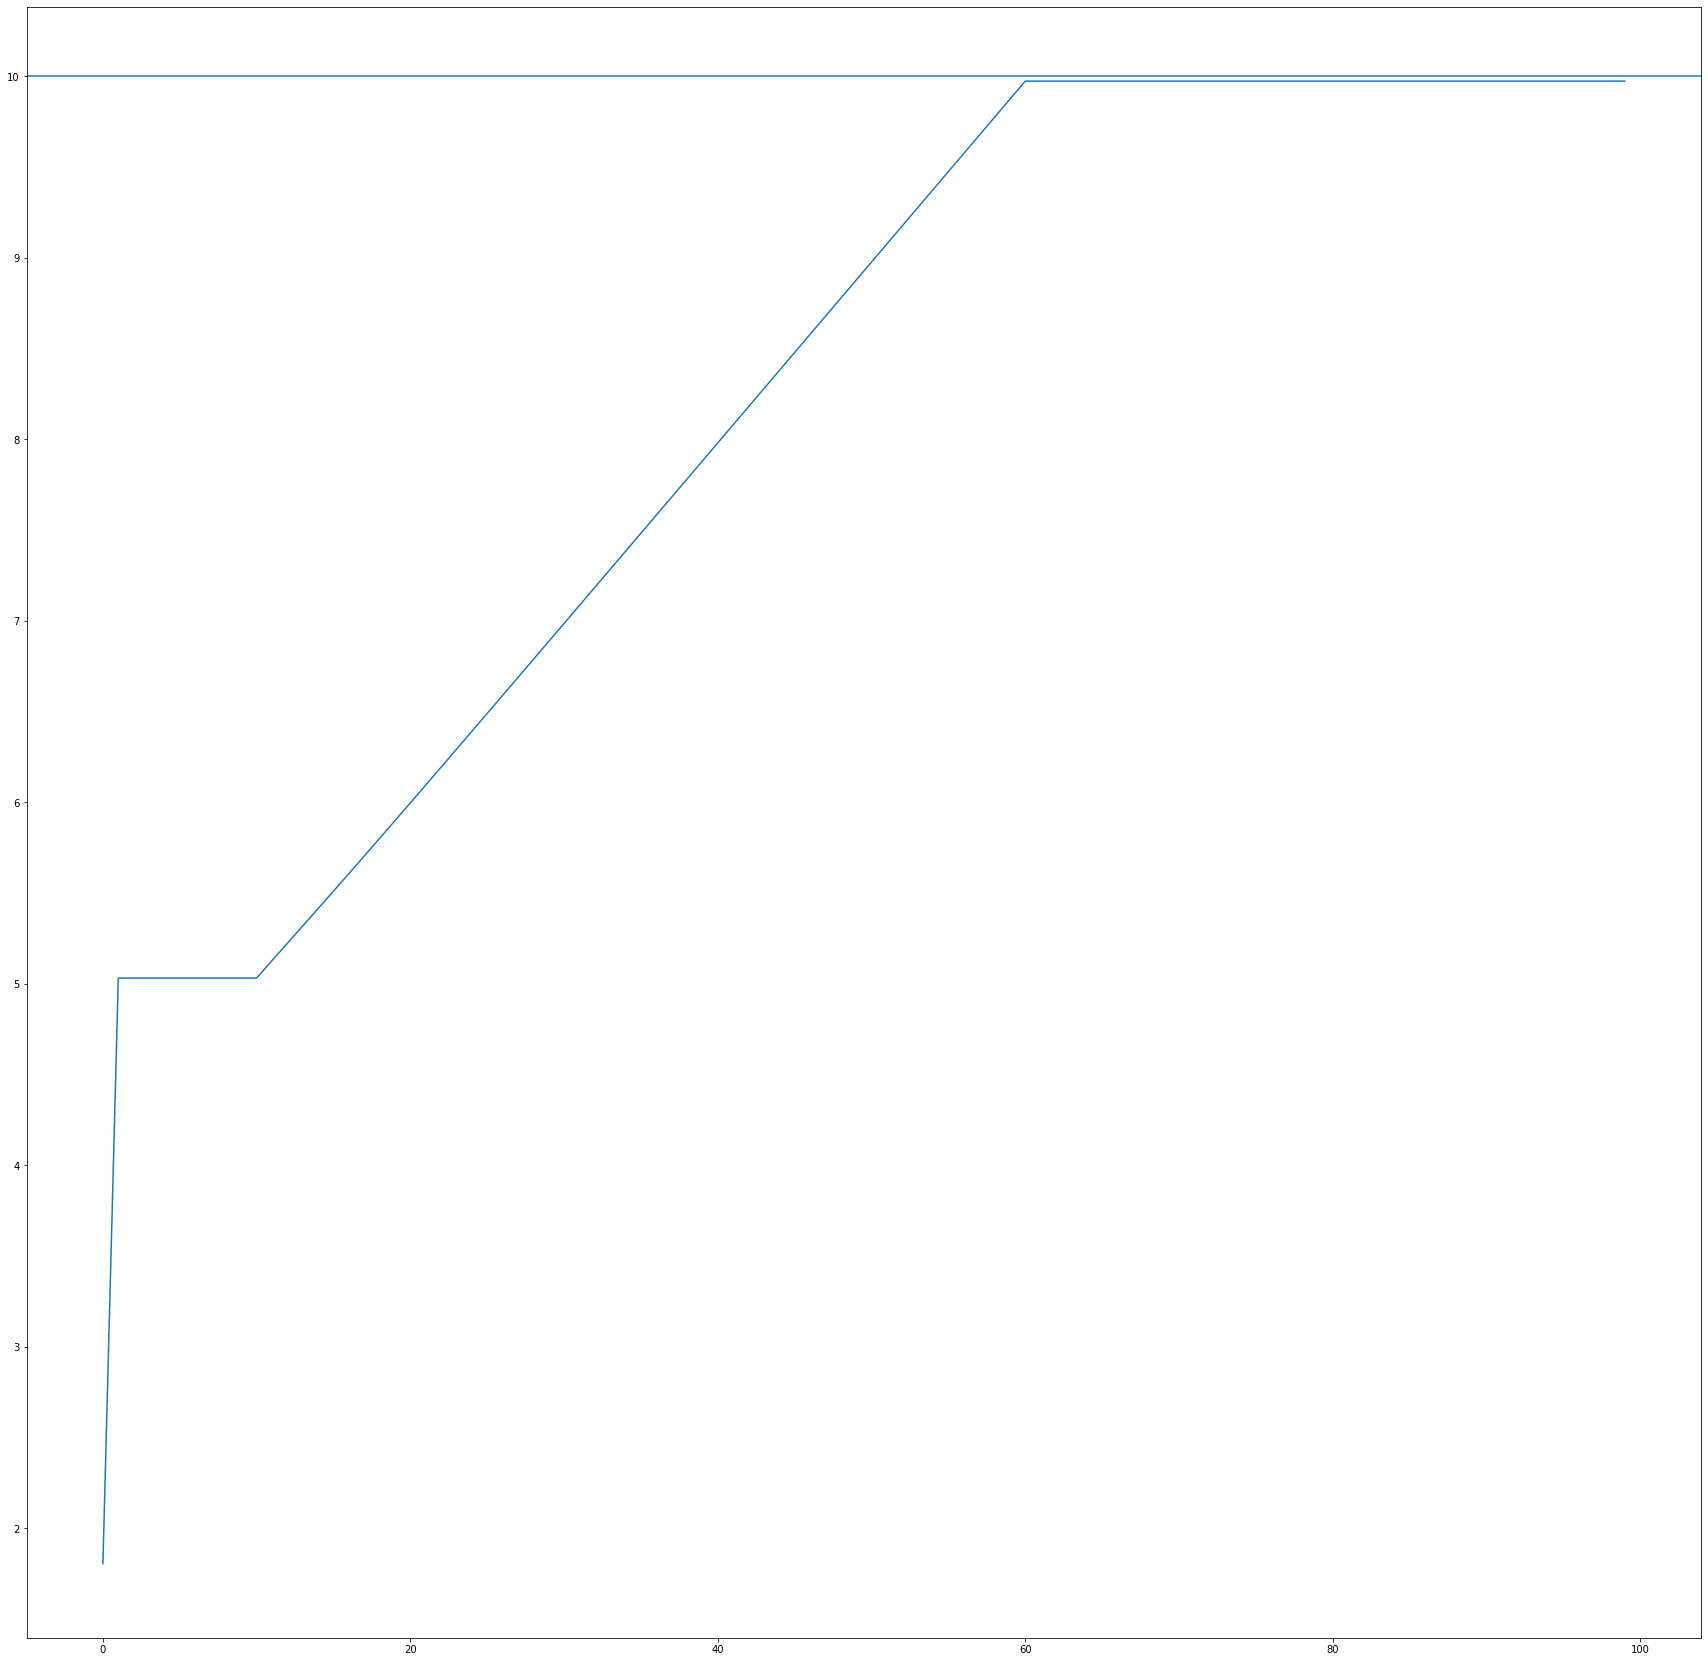

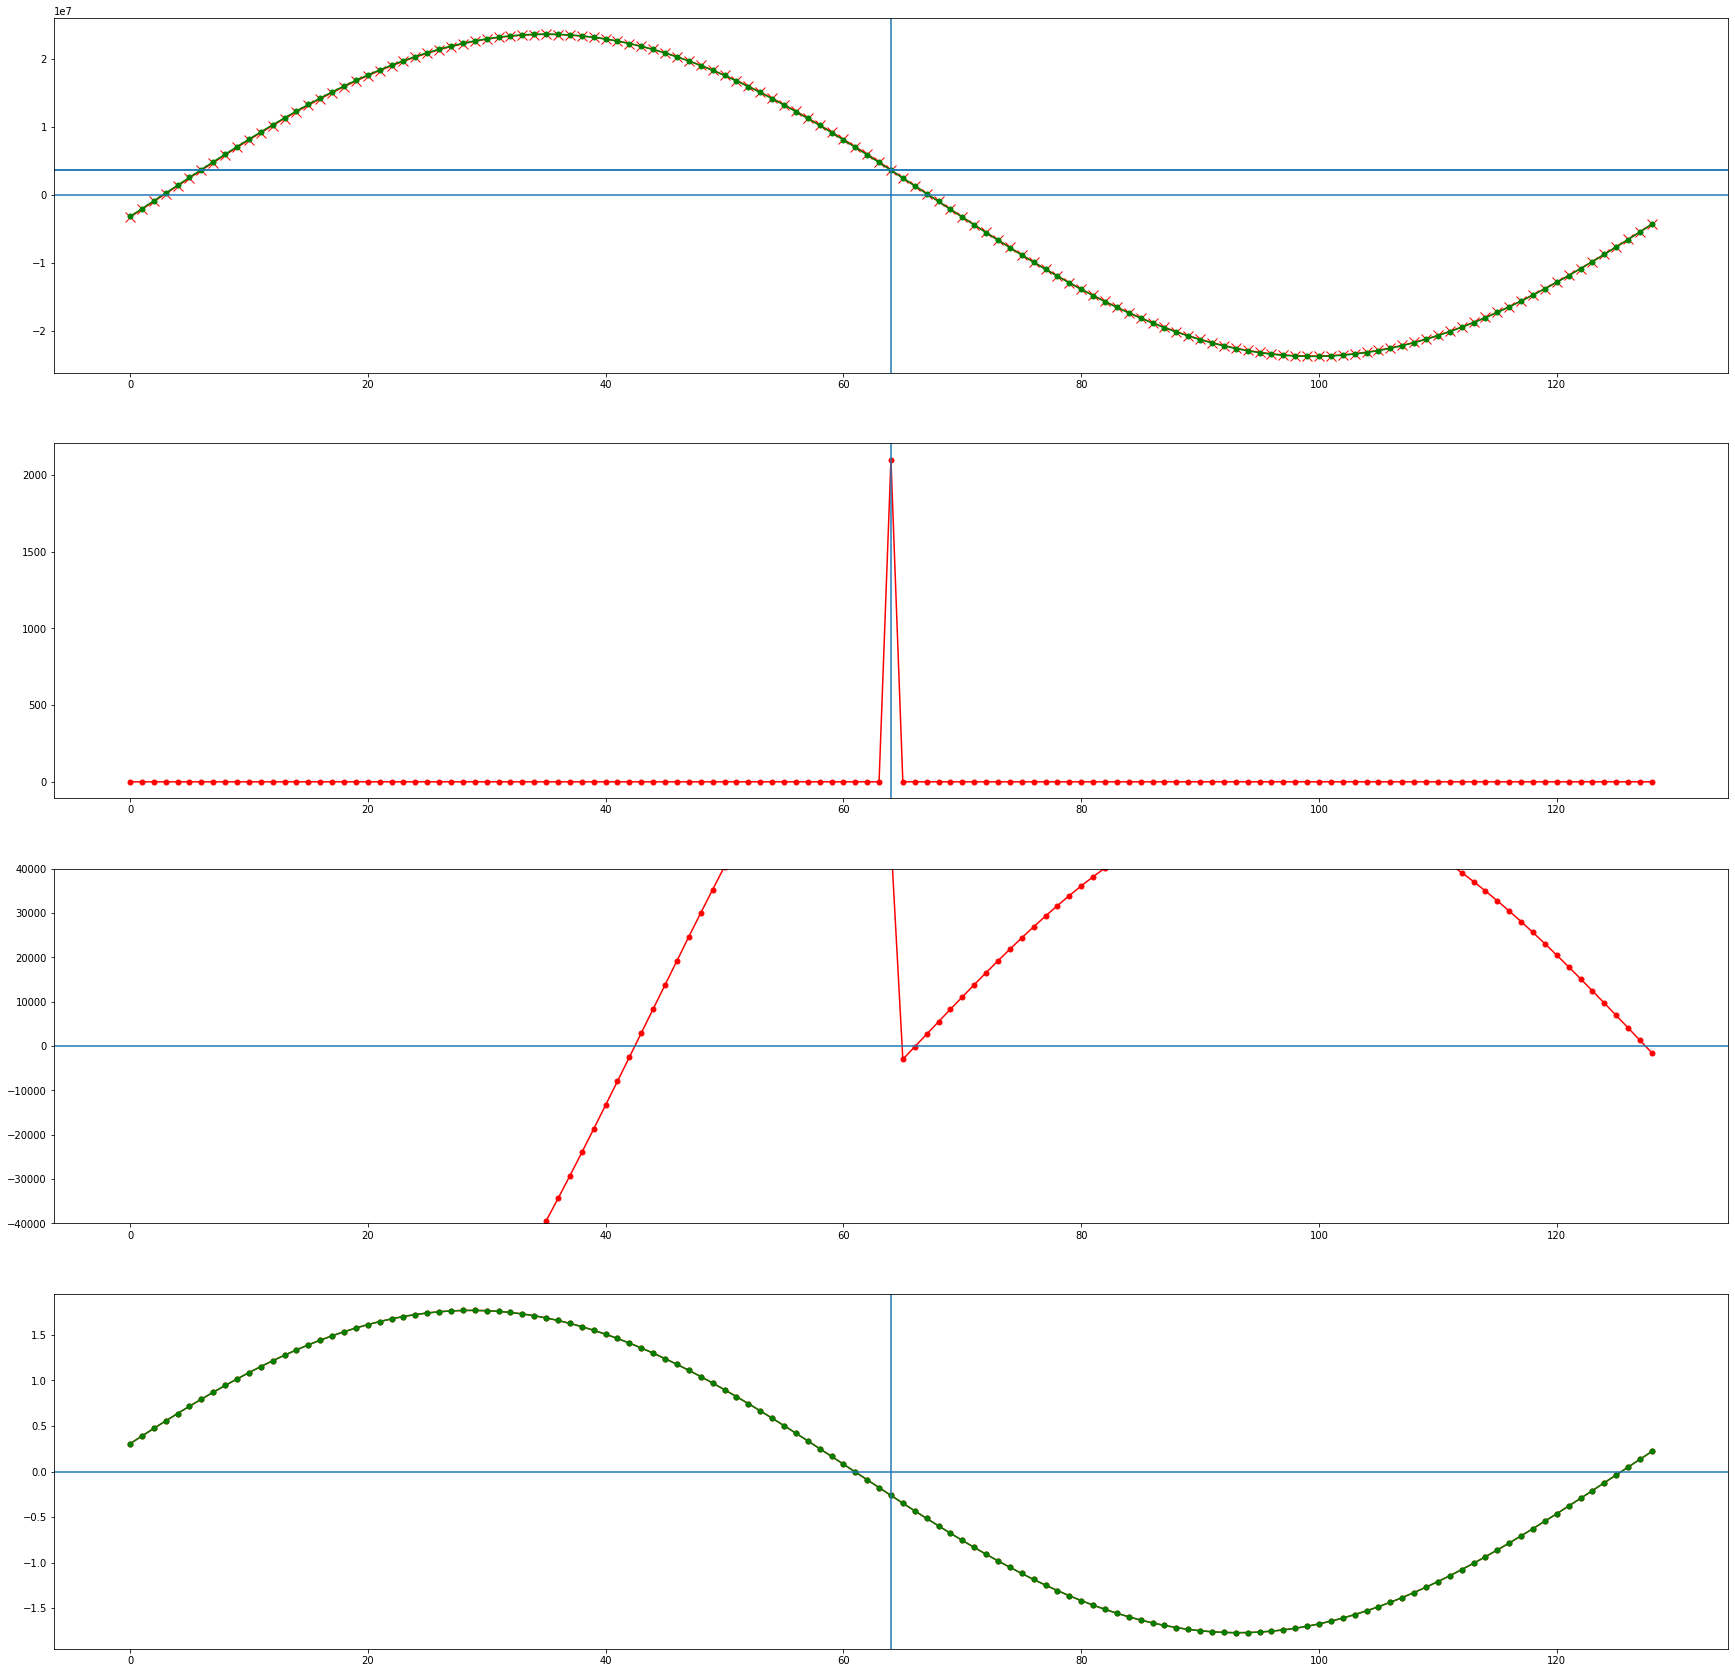

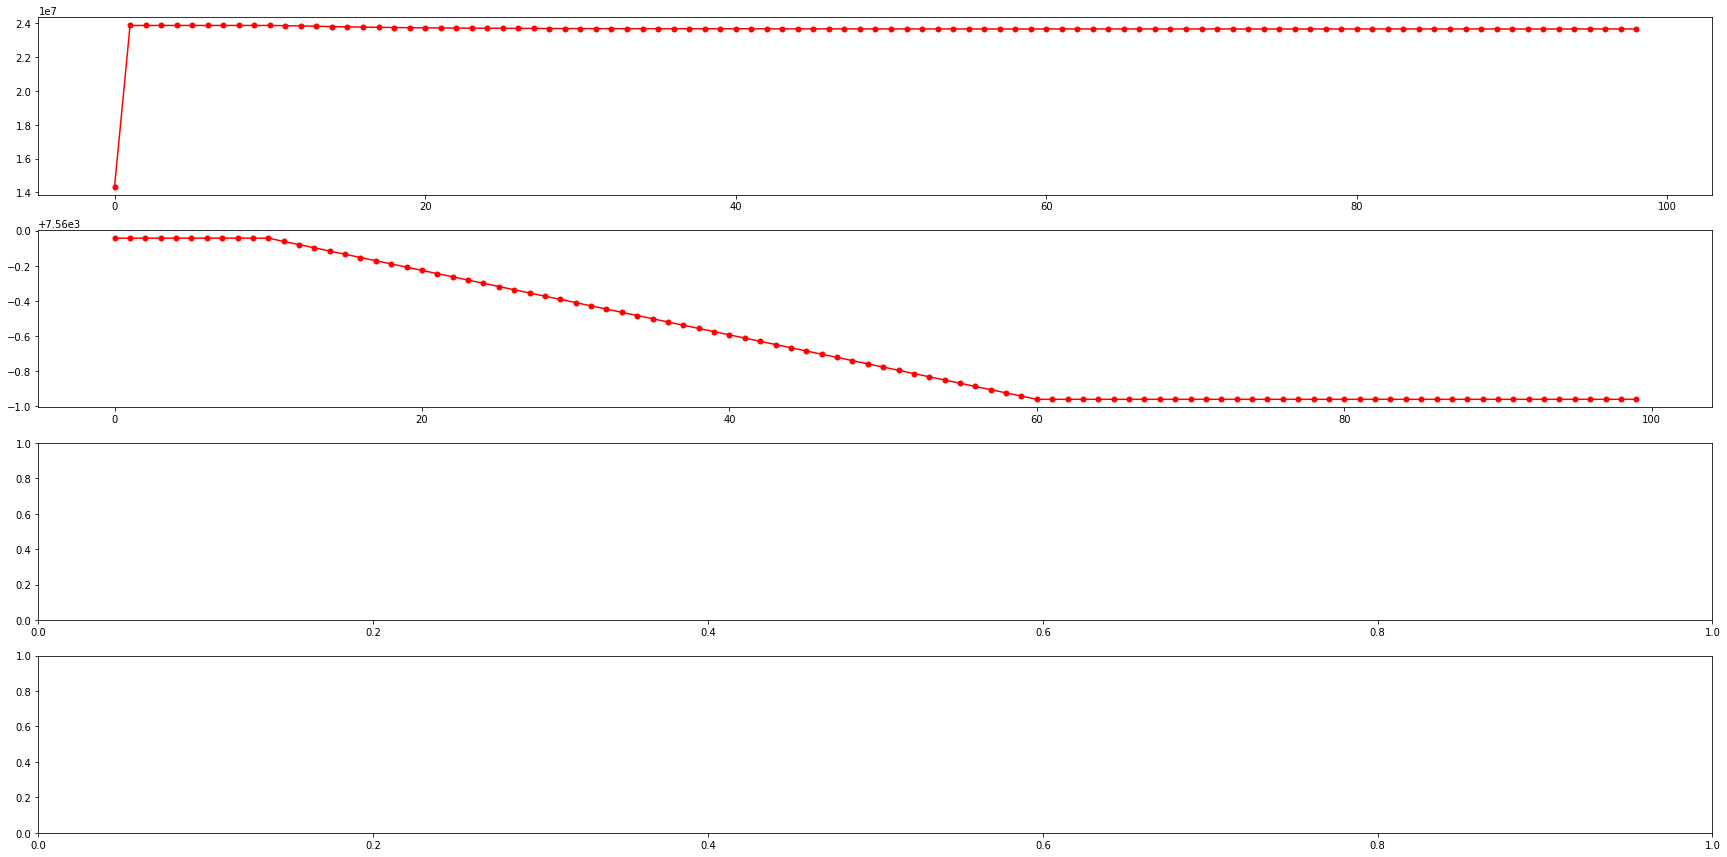

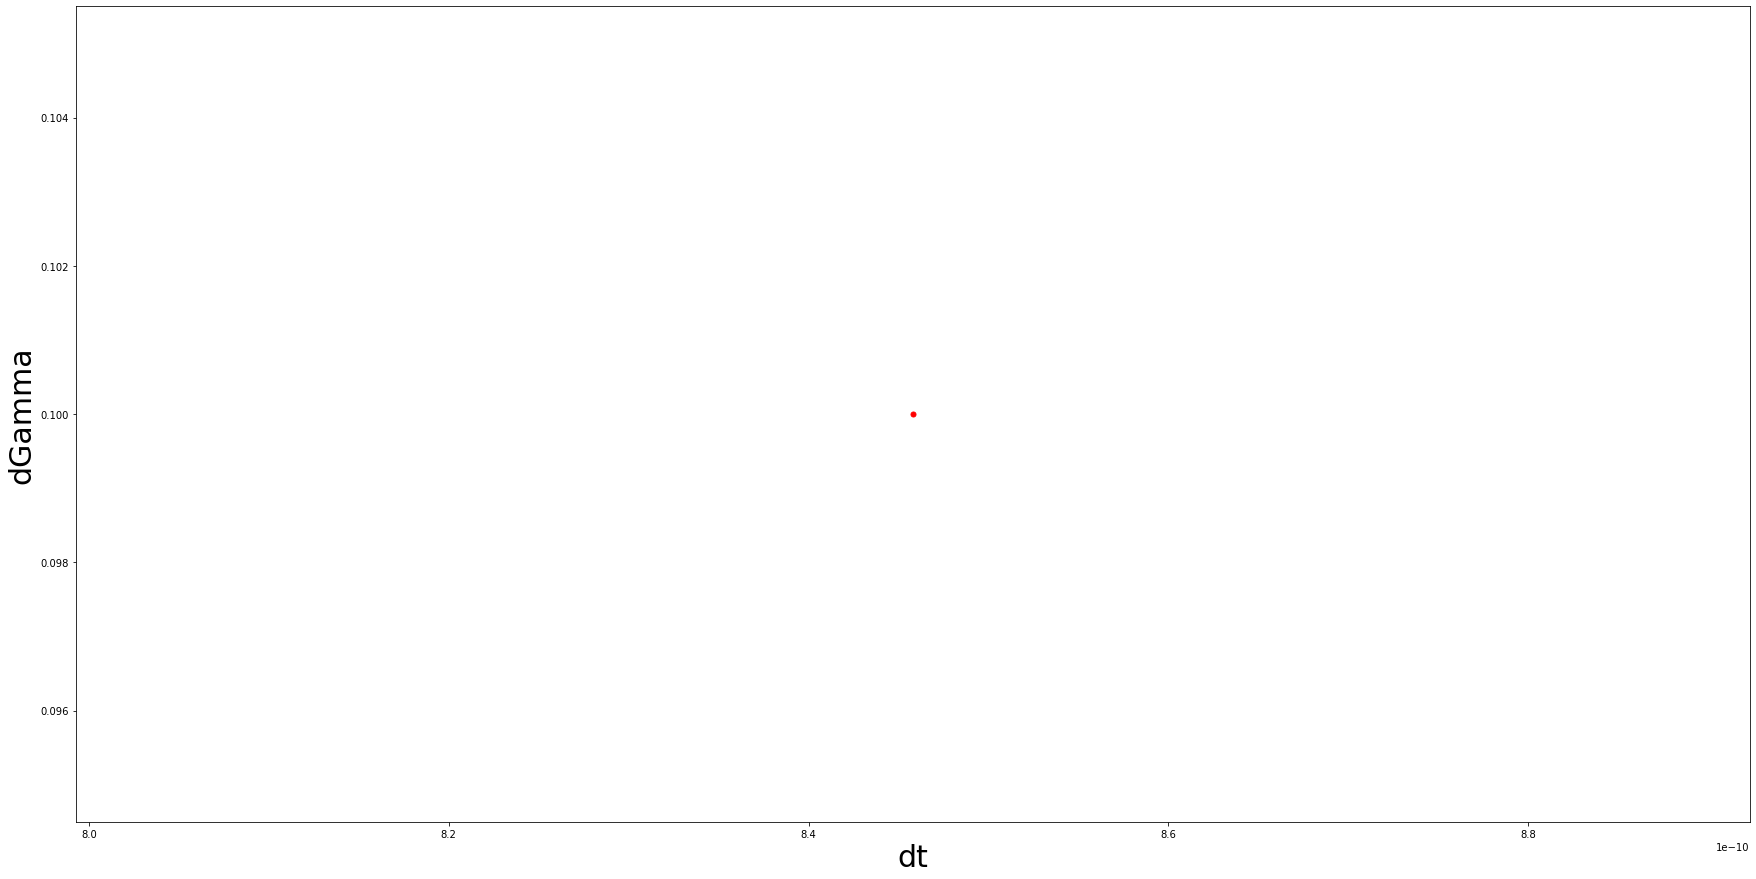

0.0
0.0
0.0


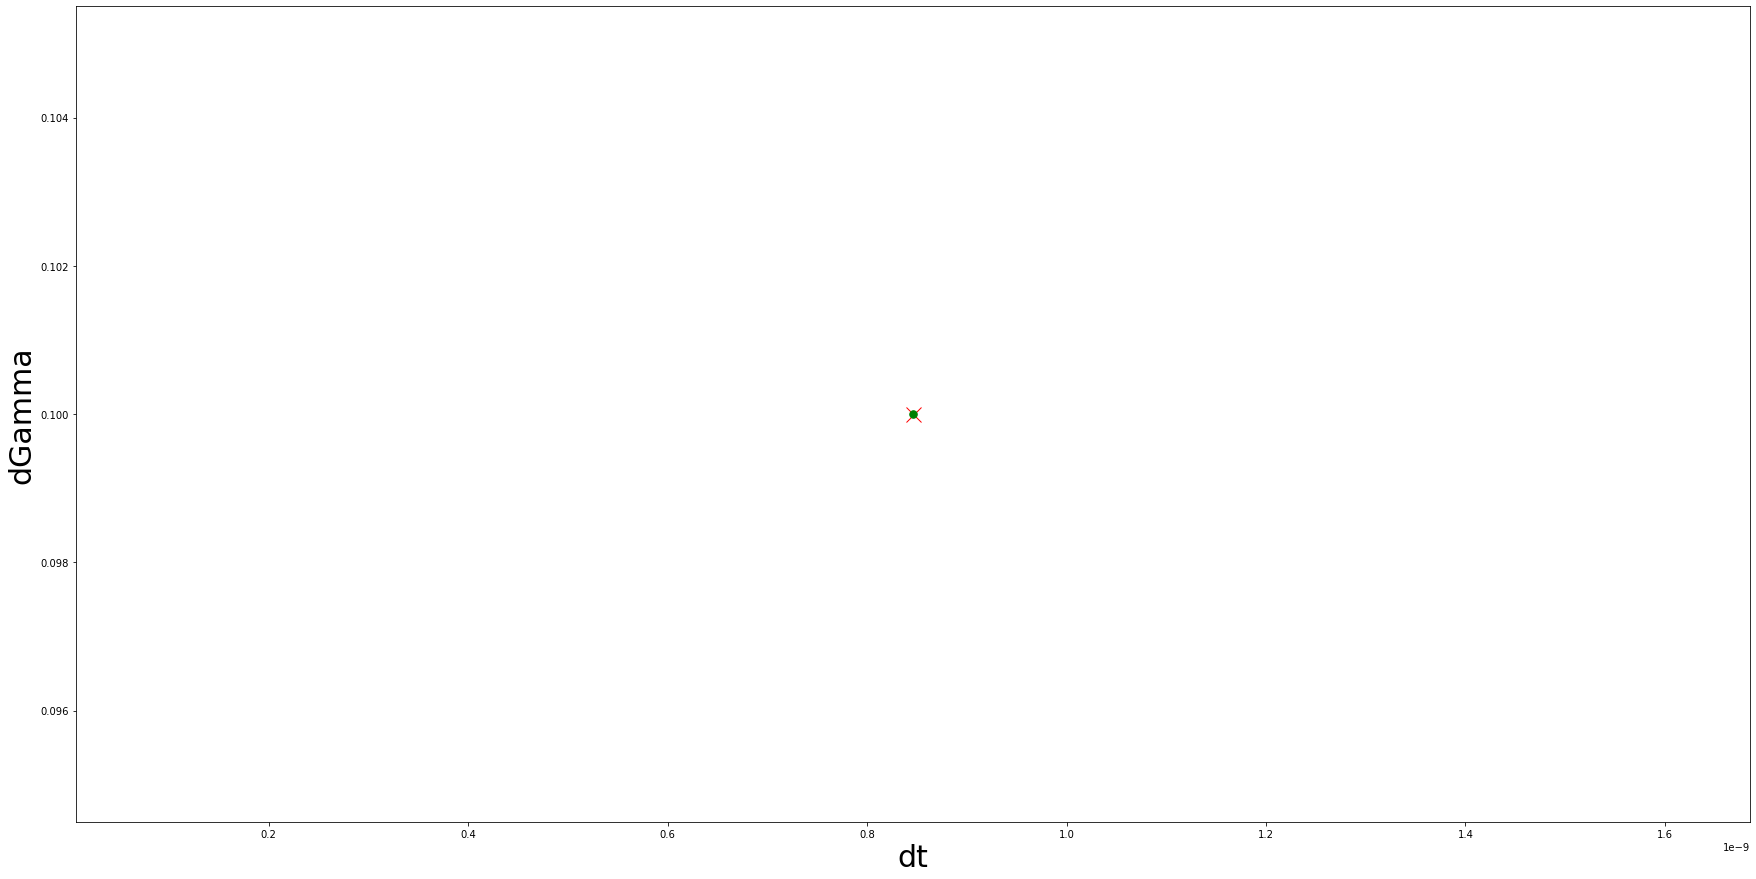

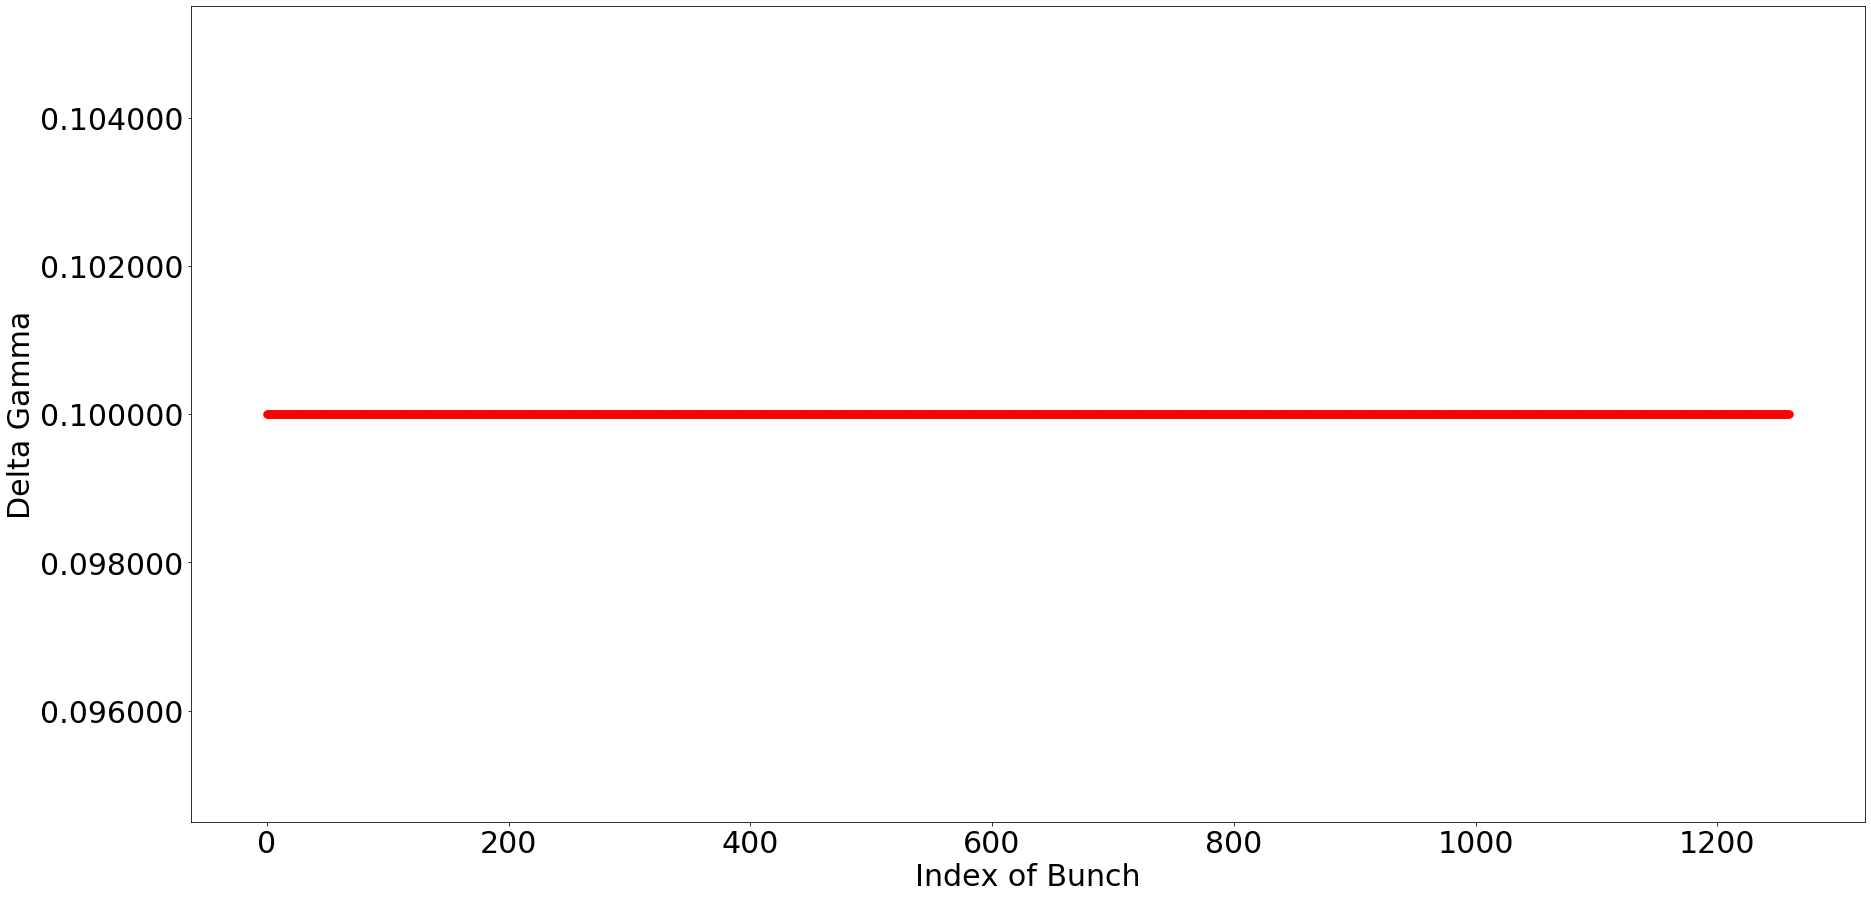

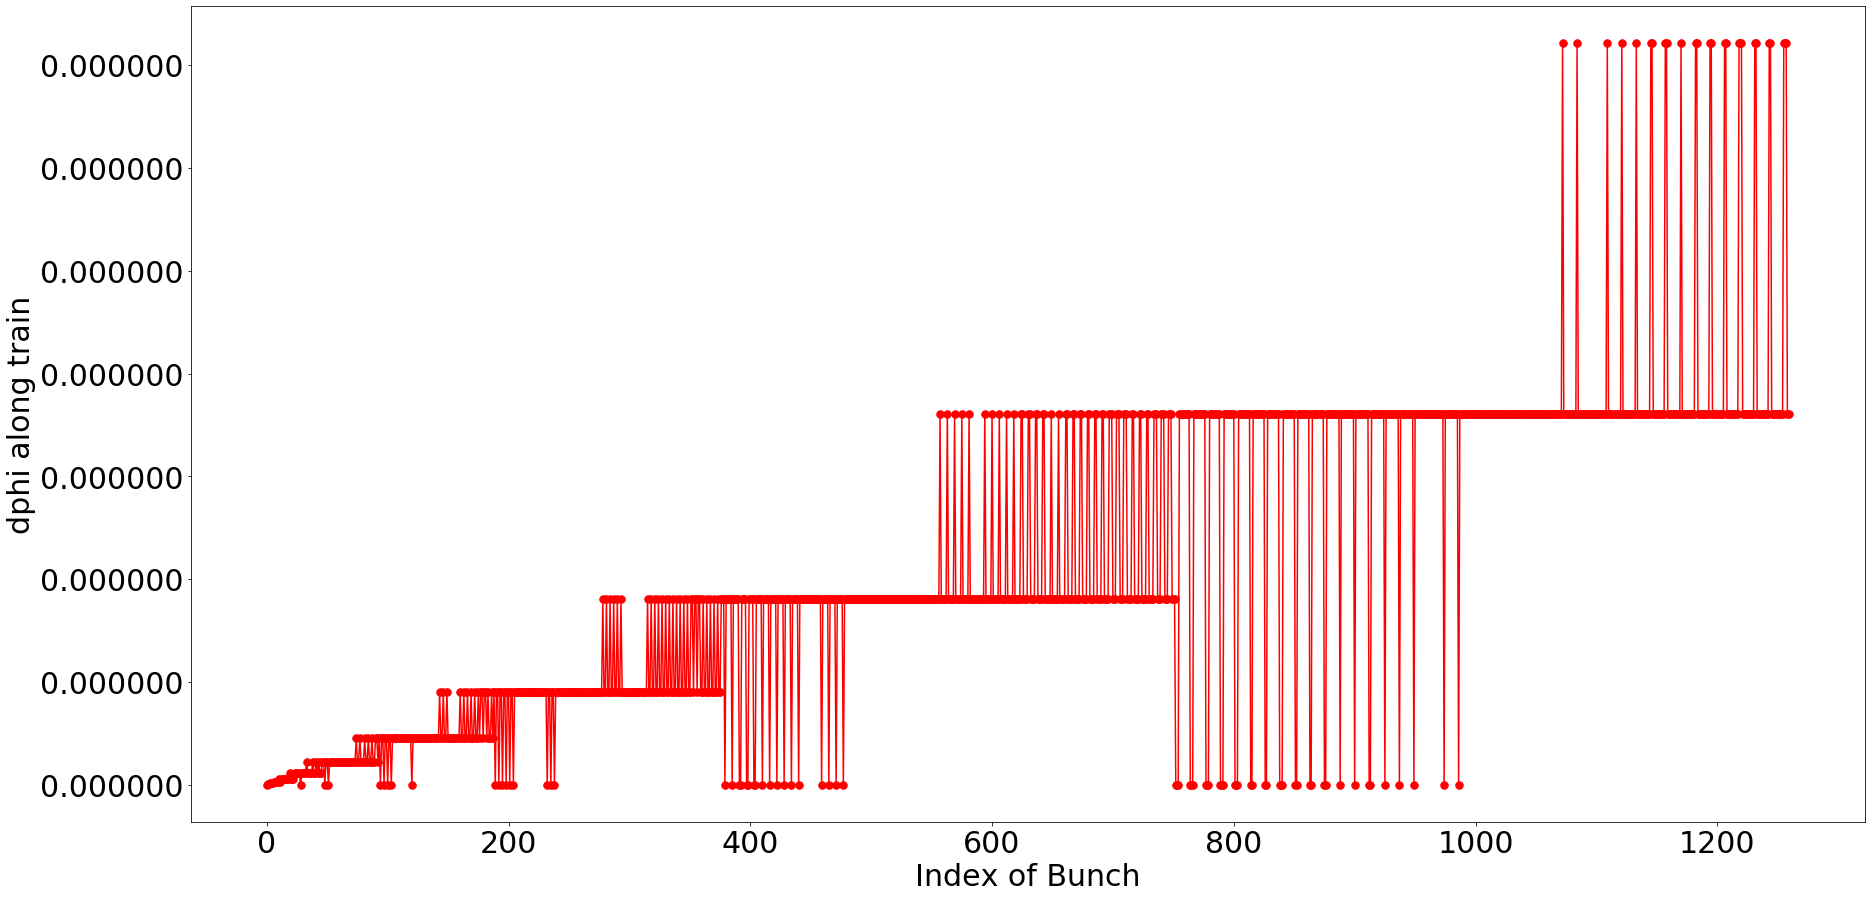

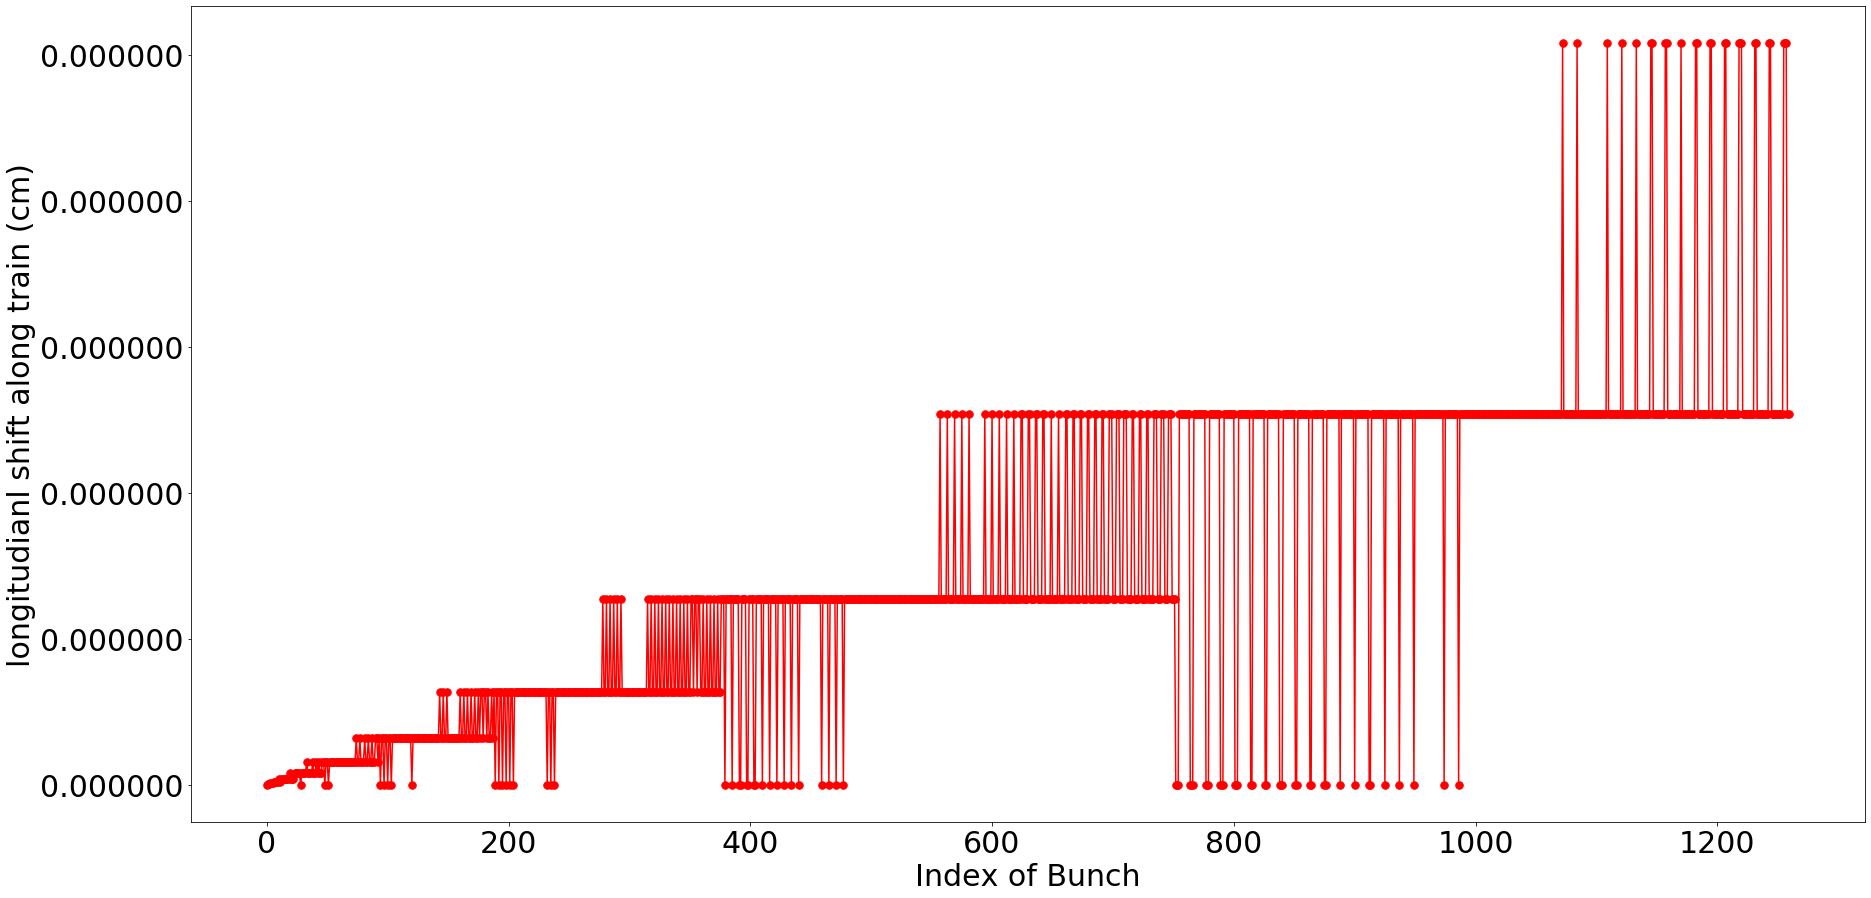

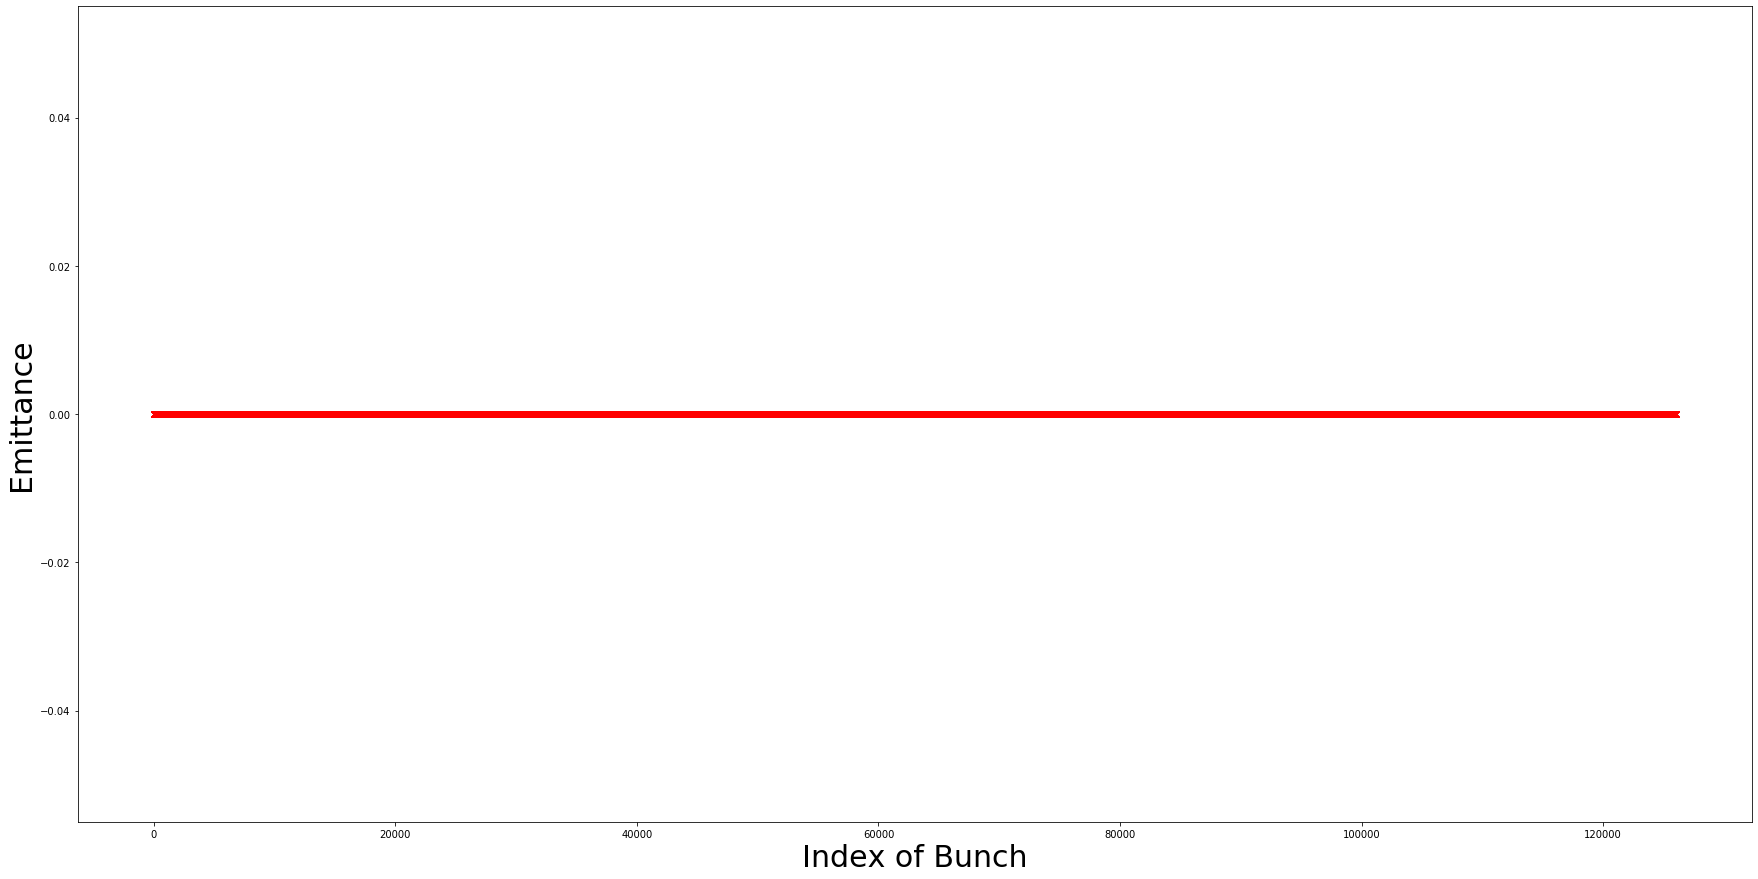

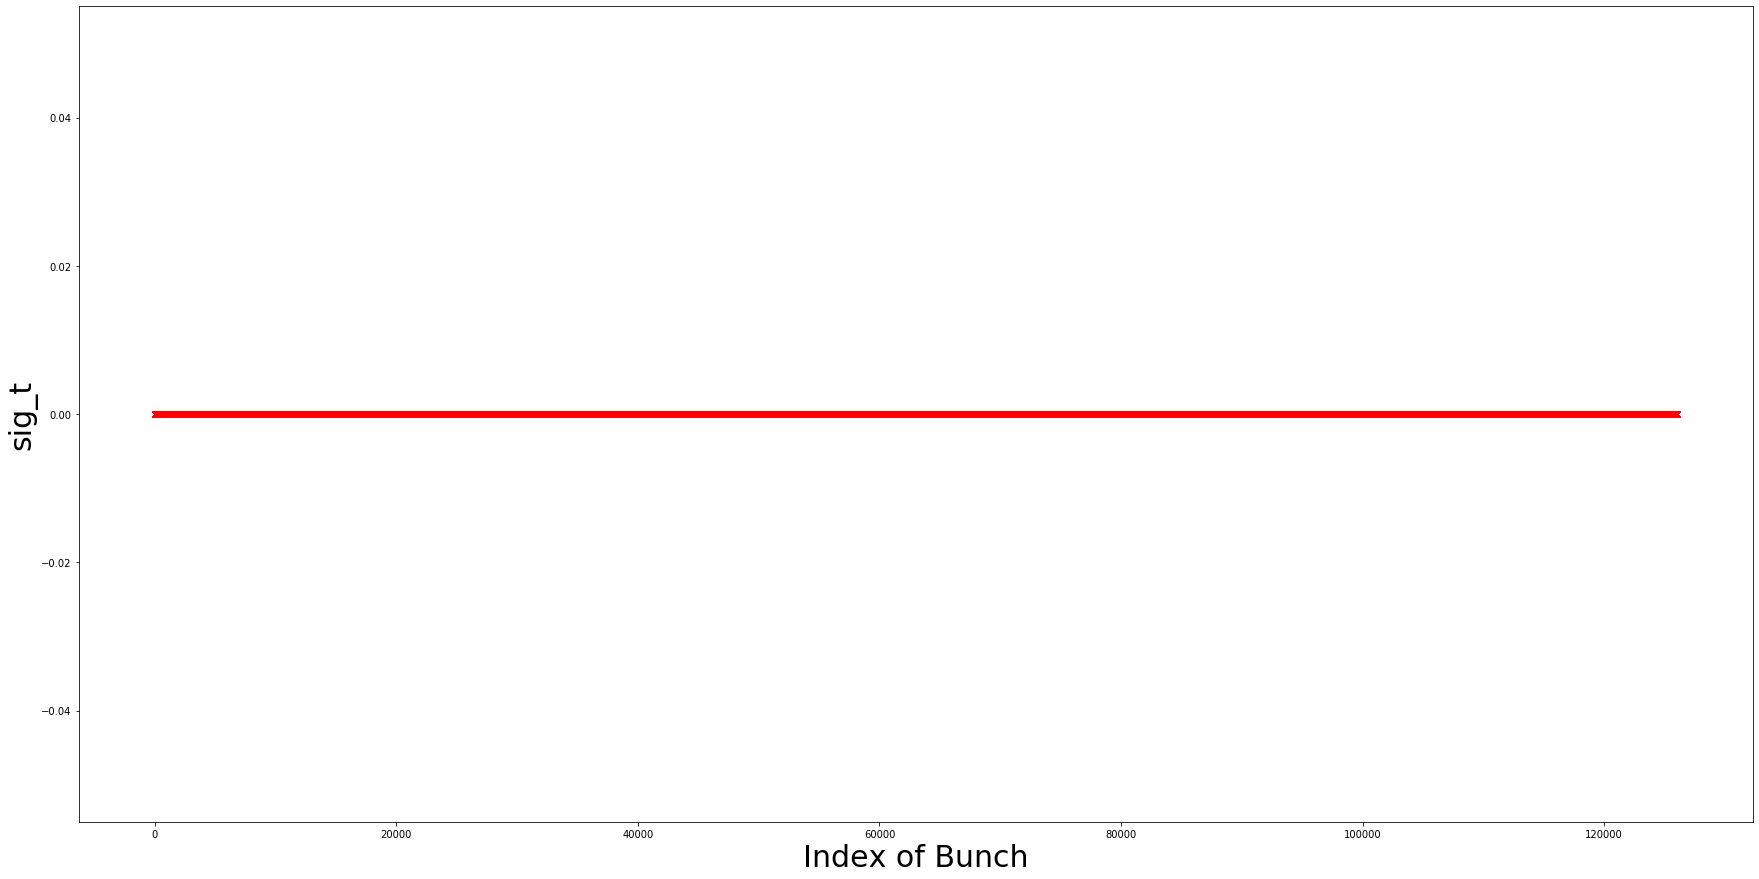

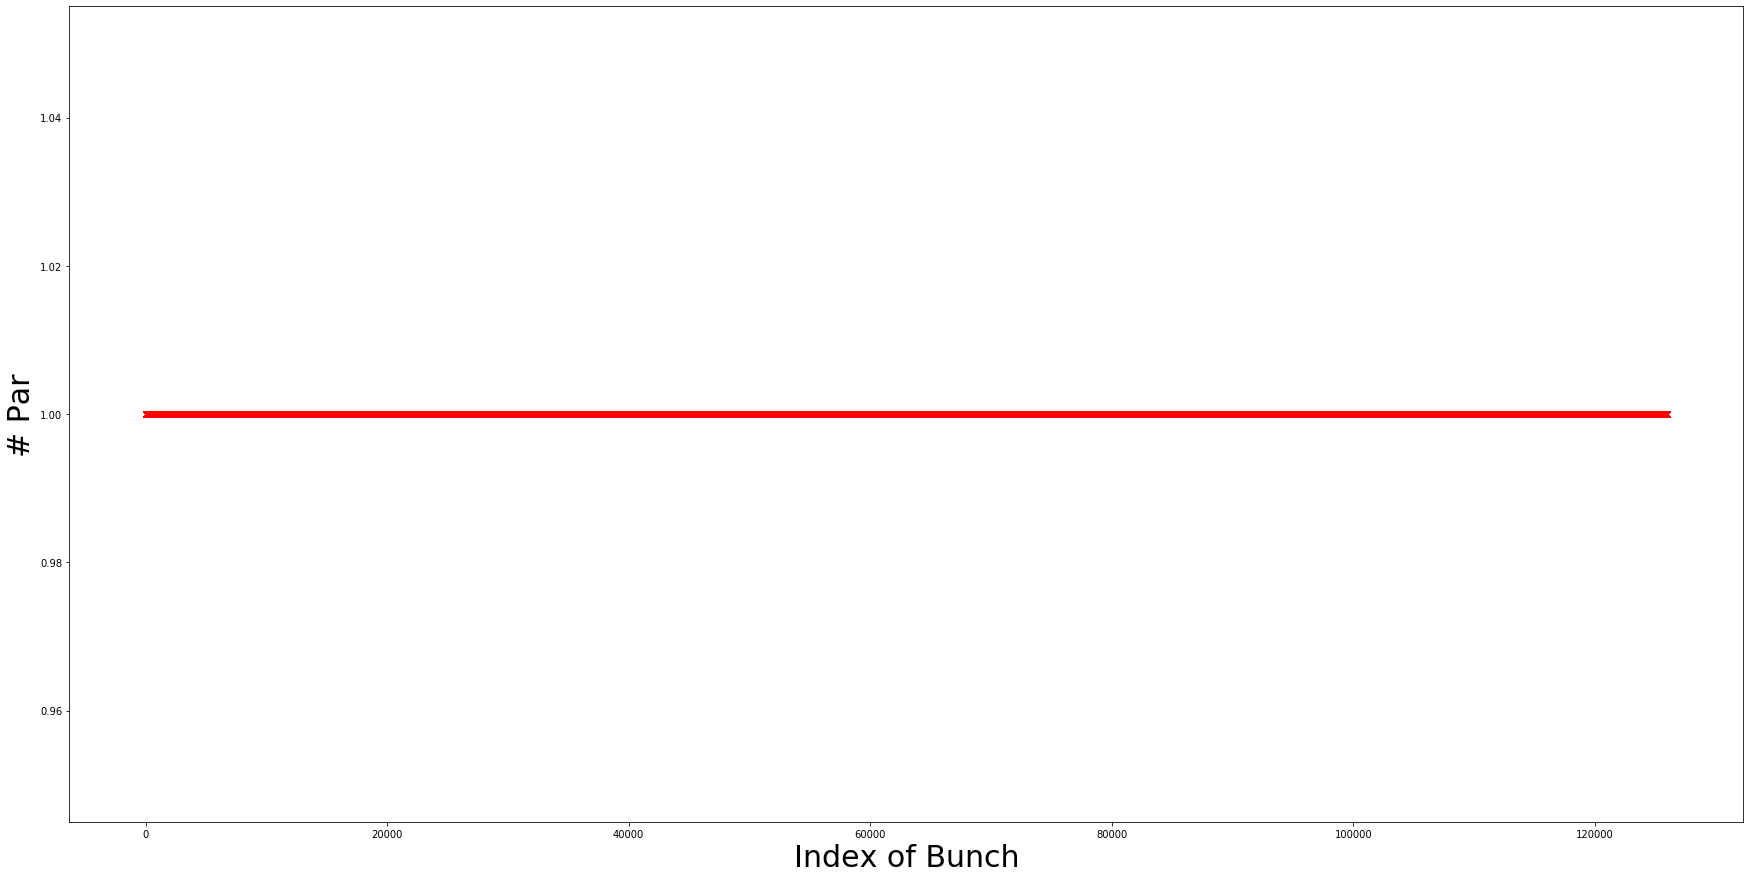

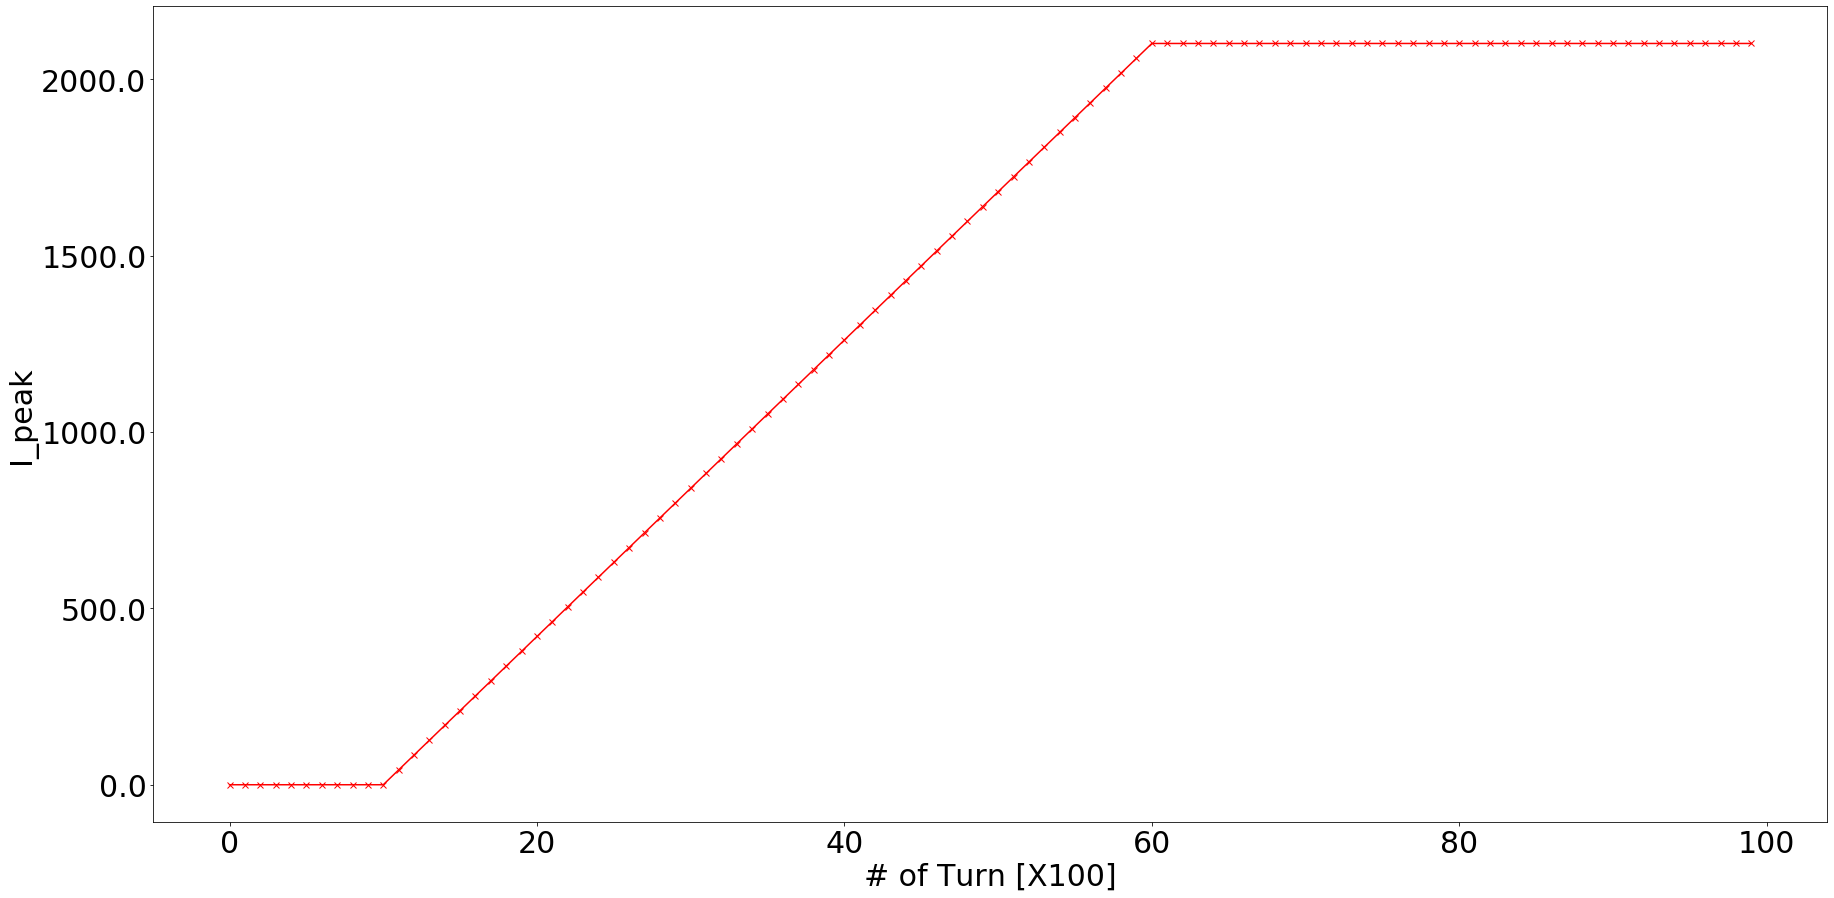

-23091.529307398818
-90185.47149330303
eta =  0.001040580123244694
Qs =  0.05409826550710491
f0 =  78196.2883627698
fs =  4230.283569519259


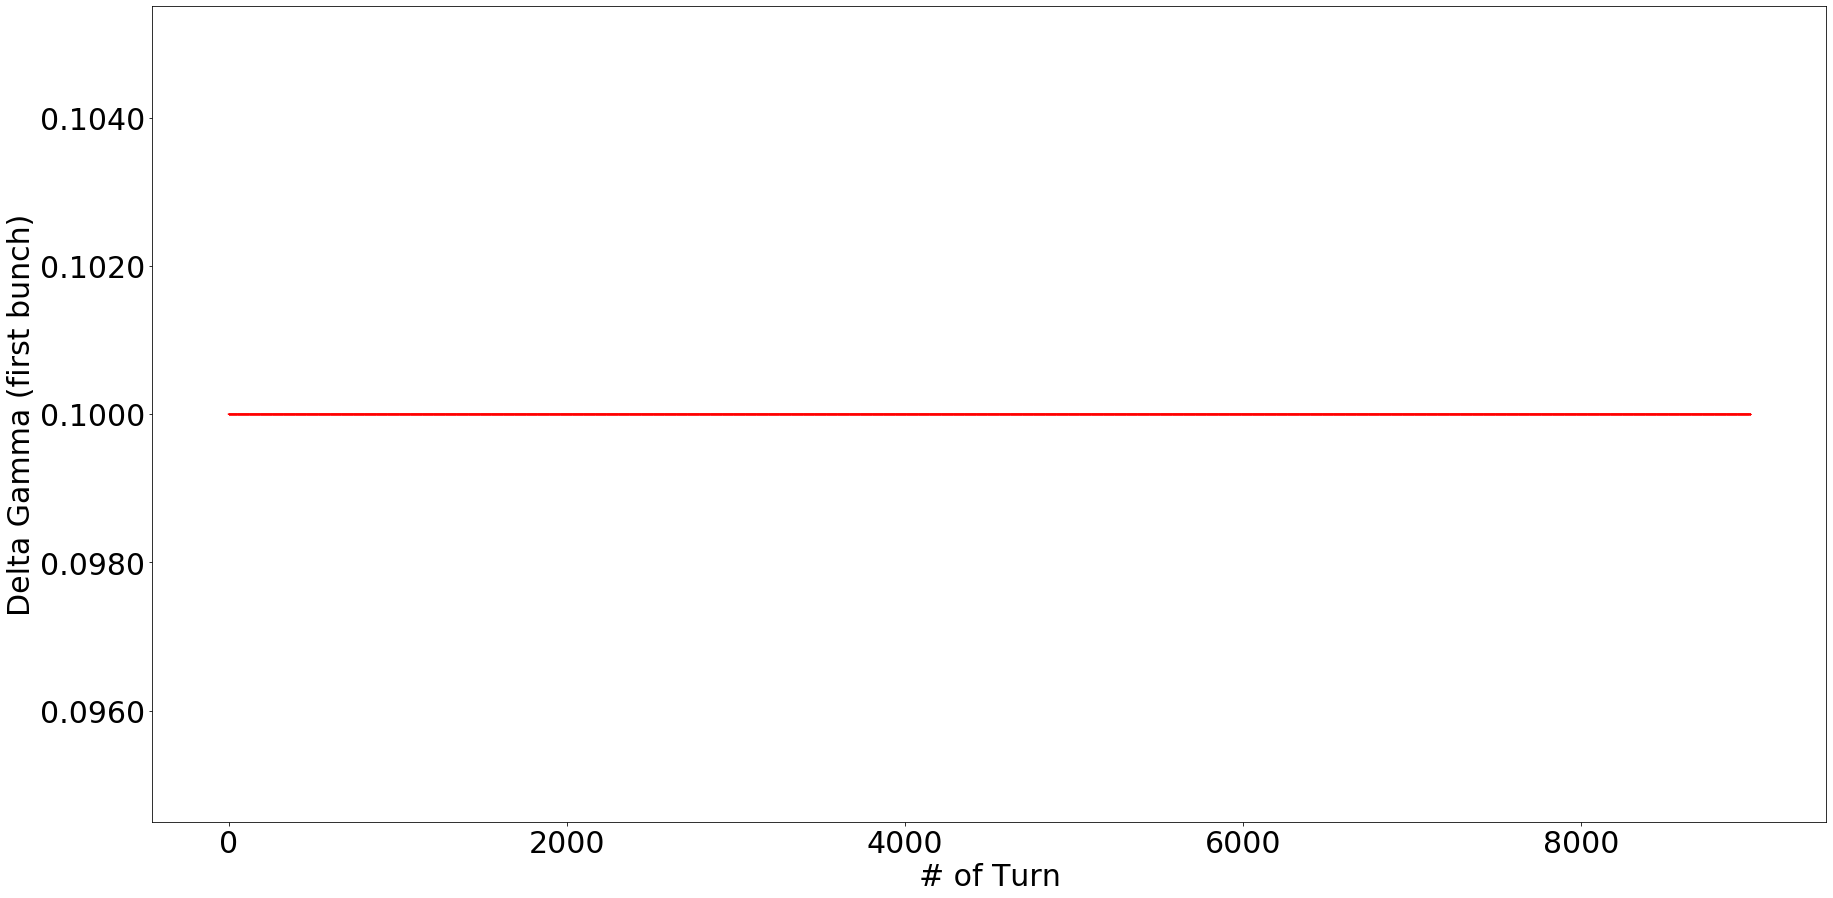

4230.283569519259
0.05409826550710491


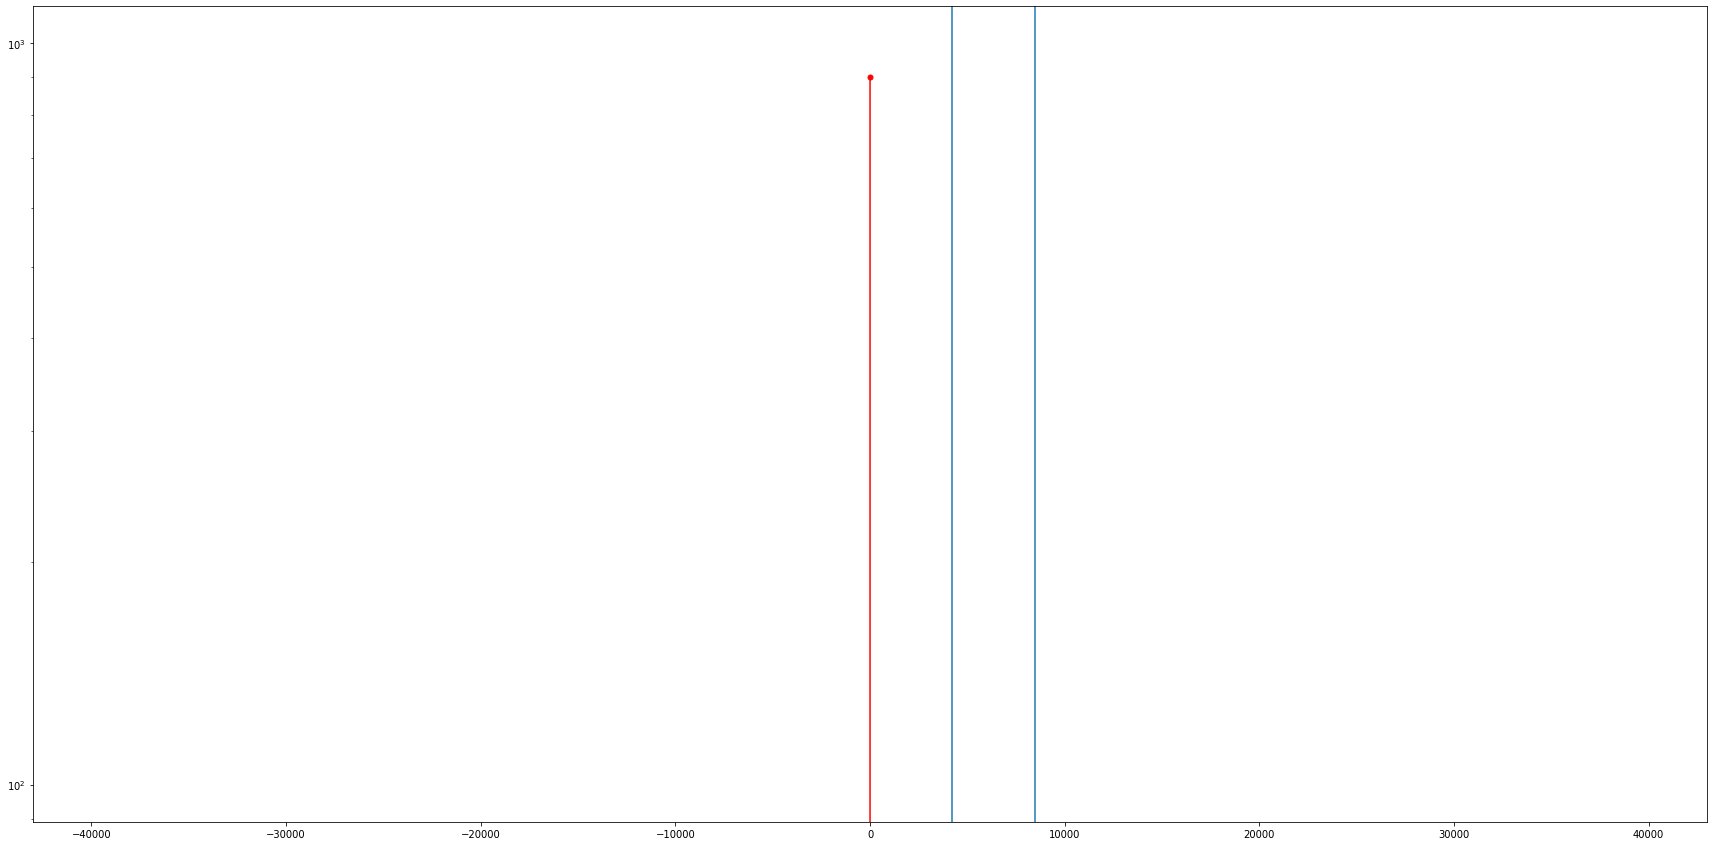

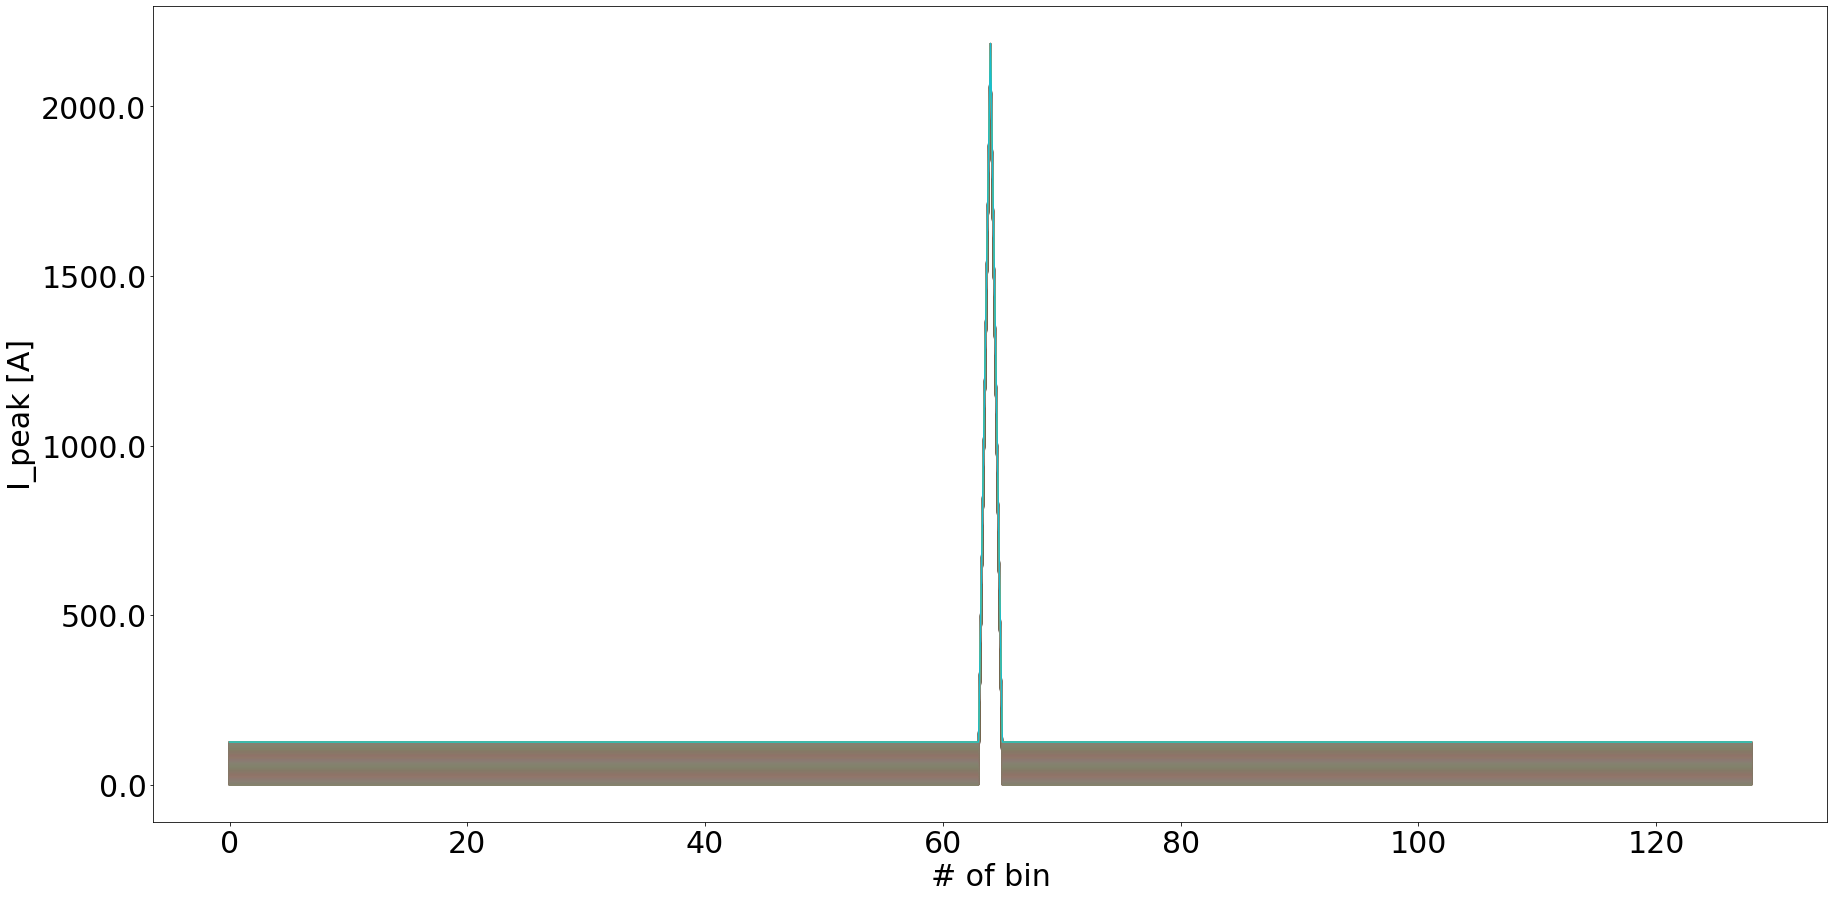

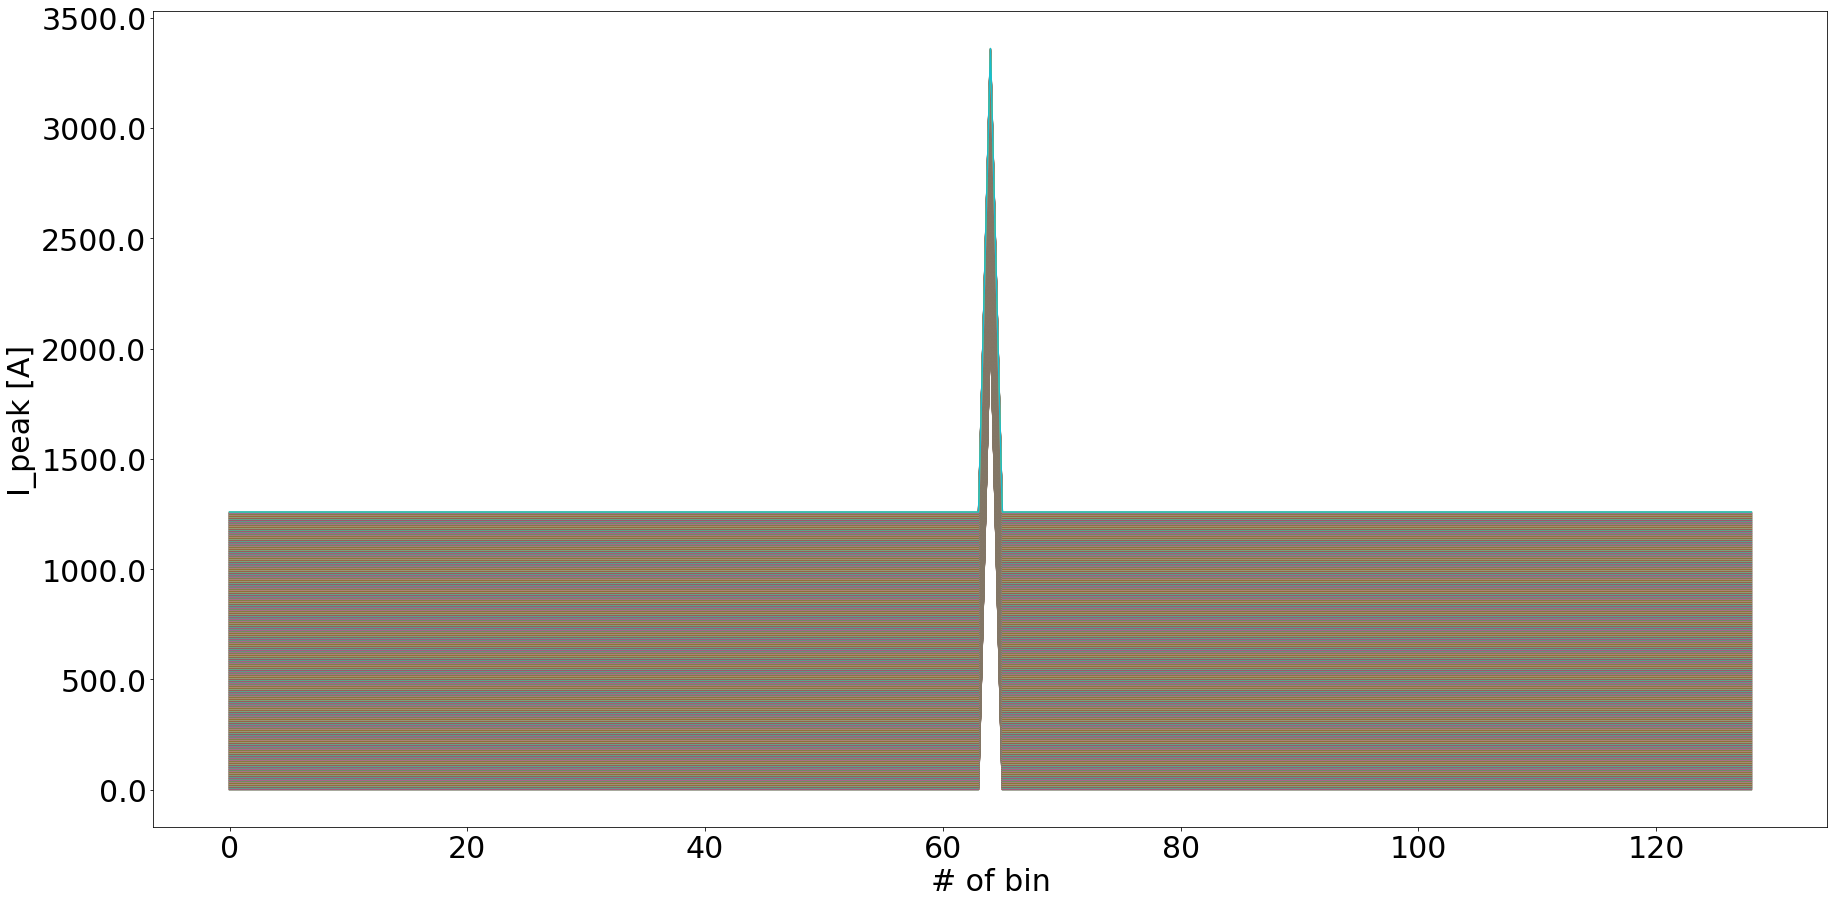

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [226]:
datafile = 'data.bin'
datafile = os.path.join(cwd,datafile)
nRF = int(tempinput['nRF'][0])
nRF1 = int(tempinput['nRF1'][0])
nRF2 = int(tempinput['nRF2'][0])
nRFc = int(tempinput['nRFc'][0])

E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
nTurns = int(tempinput['n_turns'][0])
nfill = int(tempinput['n_fill'][0])
n_q_ramp = int(tempinput['n_q_ramp'][0])
NpRF = int(tempinput['N_bins'][0])
h = [int(i) for i in tempinput['h']]
detune_ini = np.array([i for i in tempinput['detune_ini']])
detune_final = np.array([i for i in tempinput['detune_final']])

step = int(tempinput['step_store'][0])
fill_step = int(tempinput['fill_step'][0])
nBeam = int(tempinput['nBeam'][0])
beam_shift = int(tempinput['beam_shift'][0])
nBunch = int(tempinput['n_bunches'][0])
nPar = int(tempinput['Npar'][0])
NperBunch = int(tempinput['NperBunch'][0])
nTot = nBunch*nPar*nBeam
Gamma0 = tempinput['Gamma'][0]
Rring = tempinput['R'][0]
clight = 299792458
beta = np.sqrt(1-1/Gamma0**2)
T0 = 2*np.pi*Rring/(clight*beta)
f0 = 1/T0
V0 = [i for i in tempinput['Vref_I']]
V0Q = [i for i in tempinput['Vref_Q']]
II = [i for i in tempinput['Iref_I']]
IQ = [i for i in tempinput['Iref_Q']]
mainRF = int(tempinput['mainRF'][0])
if int(tempinput['type'][0]==2):
    atomicZ = 79
    Ek = Gamma0*E0Au
else:
    atomicZ =1
if int(tempinput['type'][0]==1):  
    Ek = Gamma0*E0Elec

GMTSQ = tempinput['GMTSQ'][0]
Ek_damp = tempinput['Ek_damp'][0]

eta = 1/GMTSQ-1/Gamma0**2
Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))

omegarf = 2*np.pi*(np.array(h)*f0)
omegac = 2*np.pi*(np.array(h)*f0+detune_final)
Trf = 2*np.pi/omegarf
RoQ = [i for i in tempinput['RoQ']]
QL = [i for i in tempinput['QL']]
R = [RoQ[i]*QL[i] for i in range(nRF)]

Th = 2*np.pi/omegarf[0]
dthat =Th/NpRF

pattern = 'd'+'dd'*nBeam+3*nRF*'d'
n_stride = 1+2*nBeam+3*nRF
stride = len(pattern)*8
test = array('d')
bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0

print(bucket_height)
print(Ek)
print(Qs)

with open(datafile, mode='rb') as file: # b is important -> binary
    test.fromfile(file,int((n_stride)*nTurns/step*NpRF*h[0]))

time = np.array(test[0::n_stride])
Ibi = np.array(test[1::n_stride])
#Ibi_1 = np.array(test[2::n_stride])
Ibi2 = np.array(test[3::n_stride])

V = []
Ig = []
#U = []
Vref = []
Iref = []
Power = []
for i in range(nRF):
    V.append(np.array(test[1+2*nBeam+0+i*3::n_stride]))
    Ig.append(np.array(test[1+2*nBeam+1+i*3::n_stride]))
    #U.append(np.array(test[1+2*nBeam+2+i*3::n_stride]))
    print(V0[i],V0Q[i])
    Vref.append(V0[i]*np.sin(omegarf[i]*time)+V0Q[i]*np.cos(omegarf[i]*time))
    Iref.append(II[i]*np.sin(omegarf[i]*time)+IQ[i]*np.cos(omegarf[i]*time))
    Power.append(V[i]*Ig[i])

Power_average1 = 0.5*np.array([np.mean(Power[0][i*h[0]*NpRF:(i+1)*h[0]*NpRF]) for i in range(int(n_record))])
#Power_average2 = 0.5*np.array([np.mean(Power[1][i*h[0]*NpRF:(i+1)*h[0]*NpRF]) for i in range(int(n_record))])
Power_average = Power_average1#+Power_average2
fig1,axes1 = plt.subplots(1,1)
axes1.plot(Power_average/1e6)
axes1.axhline(y = Pbeam*NC/1e6)
fig1.set_figheight(30)
fig1.set_figwidth(30)

plt.show()

startTurn =int(nTurns/step-1)
startRF = 0 
nRFsamp = 1

rng1 = NpRF*(h[0]*startTurn+startRF)+int(3*NpRF/8)*0
rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(3*NpRF/8)*0
step1 = 1
step2 = 1

if nRF>1:
    fig1,axes1 = plt.subplots(4,nRF)
    for i in range(nRF):
        axes1[0][i].plot(V[i][rng1:rng2:step1],'r.-',ms=10)
        axes1[0][i].plot((Vref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[0][i].axhline(y=0)
        axes1[0][0].axhline(y=3.7e6/14*8)
        axes1[0][1].axhline(y=3.7e6/14*6)
        axes1[0][0].axhline(y=Vnew*NF)
        axes1[0][1].axhline(y=Vnew*ND)
        axes1[0][i].axvline(x=int(NpRF/2))
        axes1[1][i].plot(Ibi[rng1:rng2:step1],'r.-',ms=10)
        if nBeam == 2 :
            axes1[1][i].plot(Ibi2[rng1:rng2:step1],'g.-',ms=10)
        axes1[2][i].plot((V[i]-Vref[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[2][i].set_ylim([-3e4,3e4])
        axes1[2][i].axvline(x=int(NpRF/2))
        axes1[3][i].plot((Ig[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[3][i].plot((Iref[i])[rng1:rng2:step1],'g-',ms=10)
        #axes1[3][i].plot((Iref[i]-Ig[i])[rng1:rng2:step1],'g-',ms=10)
        axes1[3][i].axvline(x=int(NpRF/2))
        #axes1[0][i].set_ylim([-3e6,3e6])
else:
    fig1,axes1 = plt.subplots(4,1)
    for i in range(nRF):
        axes1[0].plot(V[i][rng1:rng2:step1],'rx-',ms=10)
        axes1[0].plot((Vref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[0].axhline(y=0)
        axes1[0].axhline(y=-V0Q[0])
        axes1[0].axhline(y=-V0Q[0])
        axes1[0].axvline(x=int(NpRF/2))
        #axes1[0].set_ylim([3.0e6,4e6])
        axes1[1].plot(Ibi[rng1:rng2:step1],'r.-',ms=10)
        axes1[1].axvline(x=int(NpRF/2))
        axes1[2].plot((V[i]-Vref[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[2].set_ylim([-4e4,4e4])
        axes1[2].axhline(y=0)
        axes1[3].plot((Ig[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[3].plot((Iref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[3].axhline(y=0)
        axes1[3].axvline(x=int(NpRF/2))
fig1.set_figheight(30)
fig1.set_figwidth(30)

fn_VI = os.path.join(cwd,'VI'+str(startTurn*step)+'.jpg')
plt.savefig(fn_VI,bbox_inches='tight')
plt.show()

datafile = 'f_cav.bin'
datafile = os.path.join(cwd,datafile)
pattern = nRF*'d'
stride = len(pattern)*8
with open(datafile, mode='rb') as file: # b is important -> binary
    fileContent = file.read()
data = np.array([struct.unpack(pattern,fileContent[i*stride:(i+1)*stride]) for i in range(int(len(fileContent)/stride))]).T
frqs = []
for i in range(nRF):
    frqs.append(np.array(data[i])/2/np.pi)
V_max = []
Ig_max = []
for i in range(nRF):
    V_max.append([])
    Ig_max.append([])
    for j in range(int(len(V[i])/NpRF/h[0])-1):
        V_max[i].append(np.max(V[i][j*NpRF*h[0]:(j+1)*NpRF*h[0]]))
        #Ig_max[i].append(np.max(Ig[i][j*NpRF*h[0]:(j+1)*NpRF*h[0]]))
start = 0 # this number times n_per_step gives real turn number 
end = int(nTurns/step)
if nRF>1:
    fig1,axes1 = plt.subplots(2,nRF)
    for i in range(nRF):
        axes1[0][i].plot(V_max[i][start:end],'r.-',ms=10)
        #axes1[0][i].set_yscale('log')
        axes1[1][i].axhline(y = h[i])
        #axes1[1][i].axhline(y = omegarf[i]/(omegarf[0]/h[0])+1)
        #axes1[1][i].axhline(y = omegarf[i]/(omegarf[0]/h[0])-1)
        #axes1[2][i].plot(Ig_max[i][start:end],'r.-',ms=10)
        axes1[1][i].plot(frqs[i][start:end]/(omegarf[0]/h[0]/2/np.pi),'r.-',ms=10)        
else:
    fig1,axes1 = plt.subplots(4,1)
    for i in range(nRF):
        axes1[0].plot(V_max[i][start:end],'r.-',ms=10)
        axes1[1].plot(frqs[i][start:end]/(omegarf[0]/h[0]/2/np.pi),'r.-',ms=10)   
        #axes1[1].axhline(y = omegarf[i]/(omegarf[0]/h[0]))

fig1.set_figheight(15)
fig1.set_figwidth(30)

fn_proc = os.path.join(cwd,'process.jpg')
plt.savefig(fn_proc,bbox_inches='tight')
plt.show()

datafilepar = 'init.bin'
datafilepar = os.path.join(cwd,datafilepar)
pat = nTot*'d'
strd = nTot*8
with open(datafilepar, mode='rb') as file: # b is important -> binary
    fileContent = file.read()
datapar = np.array([struct.unpack(pat,fileContent[i*strd:(i+1)*strd]) for i in range(int(len(fileContent)/strd))])
dt_init = np.array(datapar[0])
gamma_init = np.array(datapar[1])

rng1 =  0*nPar
rng2 = int(1*nPar)
step1 = 1

fig1,axes1 = plt.subplots(1,1)

axes1.plot(dt_init[rng1:rng2:step1],gamma_init[rng1:rng2:step1]-Gamma0,'r.',ms=10)

bin_centers = [1*dthat/2+i*dthat for i in range(NpRF)]
#for bins in bin_centers:
#axes1.axvline(x = bin_centers[17])
#axes1.axvline(x = bin_centers[15])
#axes1.axvline(x = bin_centers[32])
#axes1.axvline(x = bin_centers[31])
#axes1.axvline(x = bin_centers[16])
#axes1.axvline(x = bin_centers[16]+7.7e-10)
#axes1.axvline(x = bin_centers[16]-7.7e-10)
#axes1.axhline(y = 107.35+0.05)
#axes1.axhline(y = 107.35-0.05)
#axes1.set_xlim([bin_centers[0],bin_centers[-1]])
axes1.set_xlabel('dt',fontsize=30)
axes1.set_ylabel('dGamma',fontsize=30)
fig1.set_figheight(15)
fig1.set_figwidth(30)
plt.show()

dt1 = dt_init[rng1:rng2:step1]
delta1 = gamma_init[rng1:rng2:step1]#*(197*931.5e6) # convert into eV
sig_dt1_sqr = np.sum((dt1-np.sum(dt1)/len(dt1))**2)/len(dt1)
sig_delta1_sqr = np.sum((delta1-np.sum(delta1)/len(delta1))**2)/len(delta1)
sig_dt1_delta1 = np.sum((delta1-np.sum(delta1)/len(delta1))*(dt1-np.sum(dt1)/len(dt1)))/len(delta1)
emittance = np.sqrt(sig_dt1_sqr*sig_delta1_sqr-sig_dt1_delta1**2)*np.pi*(197*931.5e6)
print(sig_dt1_sqr**0.5)
print(sig_delta1_sqr**0.5)
print(emittance*6/197)

datafilepar = 'par.bin'
datafilepar = os.path.join(cwd,datafilepar)
nData = int(nTurns/step)
par_store_tot = nTot*nData
pat = nTot*'d'*2
strd = nTot*8*2
datapar = array('d')

with open(datafilepar, mode='rb') as file: # b is important -> binary
    datapar.fromfile(file,par_store_tot*2)

dt = np.zeros(par_store_tot)
gamma = np.zeros(par_store_tot)
for i in range(nData):
    dt[i*nPar*nBunch*nBeam:(i+1)*nPar*nBunch*nBeam] = datapar[i*nBeam*nPar*nBunch*2:(i*2+1)*nPar*nBunch*nBeam]
    gamma[i*nPar*nBunch*nBeam:(i+1)*nPar*nBunch*nBeam] = datapar[(i*2+1)*nBeam*nPar*nBunch:(i*2+2)*nPar*nBunch*nBeam]
    #dt.append(datapar[i*2*nPar*nBunch*2:(i*2+1)*nPar*nBunch*2])
    #gamma.append(datapar[(i*2+1)*nPar*nBunch*2:(i*2+2)*nPar*nBunch*2])

turn_display = int(nTurns/step-1)
bunch_display = 0
nBunch_display = 1
rng11 =  turn_display*nBunch*nBeam*nPar+(bunch_display)*nPar
rng21= turn_display*nBunch*nBeam*nPar+(bunch_display+nBunch_display)*nPar

rng1 = (bunch_display)*nPar
rng2 = (bunch_display+nBunch_display)*nPar
step1 = 1

fig1,axes1 = plt.subplots(1,1)

axes1.plot(dt_init[rng1:rng2:step1],gamma_init[rng1:rng2:step1]-Gamma0,'rx',ms=15)
axes1.plot(dt[rng11:rng21:],gamma[rng11:rng21:]-Gamma0,'g.',ms=15)

bin_centers = [1*dthat/2+i*dthat for i in range(NpRF)]
#for bins in bin_centers:
#axes1.axvline(x = bin_centers[17])
#axes1.axvline(x = bin_centers[15])
#axes1.axvline(x = bin_centers[32])
#axes1.axvline(x = bin_centers[31])
#axes1.axvline(x = bin_centers[32]+3*Trf[0])
#axes1.axvline(x = bin_centers[32]+7.7e-10+3*Trf[0])
#axes1.axvline(x = bin_centers[32]-7.7e-10+3*Trf[0])
#axes1.axhline(y = 107.35+0.05)
#axes1.axhline(y = 107.35-0.05)
#axes1.set_xlim([bin_centers[0]-bunch_display/(f0*h[0])*6,bin_centers[NpRF-1]+bunch_display/(f0*h[0])*6])
axes1.set_xlim([bin_centers[0]+bunch_display*3*Trf[0],bin_centers[NpRF-1]+bunch_display*3*Trf[0]])

axes1.set_xlabel('dt',fontsize=30)
axes1.set_ylabel('dGamma',fontsize=30)
fig1.set_figheight(15)
fig1.set_figwidth(30)
plt.show()

def get_bucket_limits(bucket_lower_lim,bucket_upper_lim,beam_shift,Trf,Trev,nParPerData,nParPerTurn,nPar):
    bucket_lower_lim = np.mod(((np.mod(np.mod(bucket_lower_lim,nParPerData),nParPerTurn)/nPar).astype(int)*fill_step+(np.mod(bucket_lower_lim,nParPerData)/nParPerTurn).astype(int)*(beam_shift+0.25))*Trf,Trev)
    bucket_upper_lim = np.mod(((np.mod(np.mod(bucket_upper_lim,nParPerData),nParPerTurn)/nPar).astype(int)*fill_step+(np.mod(bucket_upper_lim,nParPerData)/nParPerTurn).astype(int)*(beam_shift+0.25)+1)*Trf,Trev)
    #bucket_lower_lim = (((bucket_lower_lim%(nParPerData))%(nParPerTurn)/nPar).astype(int)*3+((bucket_lower_lim%(nParPerData))/(nParPerTurn)).astype(int)*(beam_shift+0.5))*Trf
    #bucket_upper_lim = (((bucket_upper_lim%(nParPerData))%(nParPerTurn)/nPar).astype(int)*3+((bucket_upper_lim%(nParPerData))/(nParPerTurn)).astype(int)*(beam_shift+0.5)+1)*Trf
    return bucket_lower_lim,bucket_upper_lim
def get_mask(bucket_lower_lim, bucket_upper_lim,dt,mask):
    mask = np.abs((np.sign((dt-bucket_lower_lim)*(dt-bucket_upper_lim))-1)/2).astype(bool)
    return mask

bucket_lower_lim3 = np.arange(start=0, stop=len(dt))
bucket_upper_lim3 = np.arange(start=0, stop=len(dt))
mask = np.ones(len(dt))
bucket_lower_lim3,bucket_upper_lim3 = get_bucket_limits(bucket_lower_lim3,bucket_upper_lim3,beam_shift,Trf[0],T0,nBeam*nBunch*nPar,nBunch*nPar,nPar)

mask = get_mask(bucket_lower_lim3, bucket_upper_lim3,dt,mask)

dt_mask = dt*mask
gamma_mask = gamma*mask

t_0 = np.zeros(nData*nBeam*nBunch)
gamma_0 = np.zeros(nData*nBeam*nBunch)
nPar_mask = np.zeros(nData*nBeam*nBunch)
sig_t = np.zeros(nData*nBeam*nBunch)
sig_gamma = np.zeros(nData*nBeam*nBunch)
sig_t_gamma = np.zeros(nData*nBeam*nBunch)
emittance = np.zeros(nData*nBeam*nBunch)

for i in range(nData*nBeam*nBunch):
    nPar_mask[i] = np.sum(mask[i*nPar:(i+1)*nPar])
for i in range(nData*nBeam*nBunch):
    t_0[i] = np.sum(dt_mask[i*nPar:(i+1)*nPar])/nPar_mask[i]
    gamma_0[i] = (np.sum(gamma_mask[i*nPar:(i+1)*nPar]))/nPar_mask[i]

for i in range(nData*nBeam*nBunch):
    sig_t[i] = np.sum(((dt_mask[i*nPar:(i+1)*nPar]-t_0[i])*mask[i*nPar:(i+1)*nPar])**2)/nPar_mask[i]
    sig_gamma[i] = np.sum(((gamma_mask[i*nPar:(i+1)*nPar]-gamma_0[i])*mask[i*nPar:(i+1)*nPar])**2)/nPar_mask[i]
    sig_t_gamma[i] = np.sum((dt_mask[i*nPar:(i+1)*nPar]-t_0[i])*(gamma_mask[i*nPar:(i+1)*nPar]-gamma_0[i])*mask[i*nPar:(i+1)*nPar])/nPar_mask[i]
    #emittance[i] = np.sqrt(sig_t[i]*sig_gamma[i]-sig_t_gamma[i]**2)*np.pi*(197*931.5e6)*6/197
    emittance[i] = np.sqrt(sig_t[i]*sig_gamma[i]-sig_t_gamma[i]**2)*np.pi*(0.511e6)*6 # for electron
# plot average gamma along the train.
turn_display = int(nTurns/step-1)
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*1

fig1,axes1 = plt.subplots(1,1)

axes1.plot(gamma_0[rng1:rng2:]-Gamma0,'r.-',ms=15)

axes1.set_xlabel('Index of Bunch',fontsize=30)
axes1.set_ylabel('Delta Gamma',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.6f'))

fig1.set_figheight(15)
fig1.set_figwidth(30)
fn_train = os.path.join(cwd,'train.jpg')
plt.savefig(fn_train,bbox_inches='tight')
plt.show()

# plot average arriving time of the centroid along the train.
turn_display = int(nTurns/step-1)
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*1
centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]
fig1,axes1 = plt.subplots(1,1)

axes1.plot((t_0[rng1:rng2:]-centroids)/Trf[0]*360,'r.-',ms=15)

axes1.set_xlabel('Index of Bunch',fontsize=30)
axes1.set_ylabel('dphi along train',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.6f'))

fig1.set_figheight(15)
fig1.set_figwidth(30)
fn_train = os.path.join(cwd,'train.jpg')
plt.savefig(fn_train,bbox_inches='tight')
plt.show()

# plot average distance shift of the centroid along the train.
turn_display = int(nTurns/step-1)
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*1
centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]
fig1,axes1 = plt.subplots(1,1)

axes1.plot((t_0[rng1:rng2:]-centroids)*clight*100,'r.-',ms=15)

axes1.set_xlabel('Index of Bunch',fontsize=30)
axes1.set_ylabel('longitudianl shift along train (cm)',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.6f'))

fig1.set_figheight(15)
fig1.set_figwidth(30)
fn_train = os.path.join(cwd,'train_dist.jpg')
plt.savefig(fn_train,bbox_inches='tight')
plt.show()


# emittance plot
turn_display = 0
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*200

fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.plot(emittance[rng1:rng2:],'rx-')
axes1.set_xlabel('Index of Bunch',fontsize=30)
axes1.set_ylabel('Emittance',fontsize=30)
fn_emittance = os.path.join(cwd,'Emittance.jpg')
plt.savefig(fn_emittance,bbox_inches='tight')
plt.show()

# bunch length plot
turn_display = 0
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*200

fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.plot(sig_t[rng1:rng2:]*clight,'rx-')
axes1.set_xlabel('Index of Bunch',fontsize=30)
axes1.set_ylabel('sig_t',fontsize=30)
fn_length = os.path.join(cwd,'length.jpg')
plt.savefig(fn_length,bbox_inches='tight')
plt.show()
# particle loss
turn_display = 0
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*200

fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
bin_centers = [1*dthat/2+i*dthat for i in range(NpRF)]

axes1.plot(nPar_mask[rng1:rng2:],'rx')
axes1.set_xlabel('Index of Bunch',fontsize=30)
axes1.set_ylabel('# Par',fontsize=30)
plt.show()

# I peak
I_peak = np.zeros(nData)
for i in range(nData):
    I_peak[i] = np.max(Ibi[i*NpRF*h[0]:(i+1)*NpRF*h[0]])

fig1,axes1 = plt.subplots(1,1)
axes1.plot(I_peak,'rx-')

fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.set_xlabel('# of Turn [X'+str(step)+']',fontsize=30)
axes1.set_ylabel('I_peak',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
fn_Ipeak = os.path.join(cwd,'Ipeak.jpg')
plt.savefig(fn_Ipeak,bbox_inches='tight')
plt.show()

datafilepar = 'first.bin'
datafilepar = os.path.join(cwd,datafilepar)
with open(datafilepar, mode='rb') as file: # b is important -> binary
    fileContent = file.read()
datapar = np.array([struct.unpack('dd',fileContent[i*16:(i+1)*16]) for i in range(int(len(fileContent)/16))]).T
first_dt = np.array(datapar[0])
first_gamma = np.array(datapar[1])

def Zparallel(Rsh, QL, omega0, omega):
    return Rsh/(1+1j*QL*(omega/omega0-omega0/omega))

#r0 = (79*1.6e-19)**2/(197*1.7e-27*3e8*3e8) # gold
#r0 = (1*1.6e-19)**2/(1*1.7e-27*3e8*3e8) # Proton
r0 = (1*1.6e-19)**2/(1*9.10938356e-31*3e8*3e8)

pmax = nBunch # number of samples 
mu = 1#h[mainRF]%nBunch # 

ps = np.array([float(i) for i in range(-pmax,pmax)])
ps[pmax]=1e-16 # get rid of the zero point to avoid 1/0 problem in python

# for the calculation of real part of Omega
p_M_omega0 = ps*nBunch*2*np.pi*f0
Zs0 = np.array([Zparallel(R[i],QL[i],omegac[i],p_M_omega0) for i in range(nRF)])
factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*Qs*f0*2*np.pi)
delta_omegas = factor1*np.sum(p_M_omega0*np.imag(Zs0))
omegas = Qs*2*pi*f0+delta_omegas

omegas1 = ((ps*nBunch+mu)*2*np.pi*f0+omegas)
Zs1 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas1) for i in range(nRF)])
factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*omegas)
deltaOmegaRe = -factor1*np.sum(omegas1*np.imag(Zs1))

# for the calculation of the imaginary part of Omega
omegas2 = ((ps*nBunch+mu)*2*np.pi*f0+(omegas))

factor2 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*(omegas))

Zs2 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas2) for i in range(nRF)])
deltaOmegaIm = factor2*np.sum(omegas2*np.real(Zs2))
print(deltaOmegaRe)
print(deltaOmegaIm)

# Fitted
def func_exp_fit(x, a, b, c):
    return a*np.exp(b*x)+c
if 0:
    startTurn = 0
    endTurn = 1000
    delta_gamma_env = np.zeros(int((endTurn-startTurn)*Qs))
    TTurns = int(1/Qs) # numbers of turns per synchrotron oscillation
    delta_gamma_turn = np.array([i*TTurns+startTurn for i in range(len(delta_gamma_env))])
    delta_gamma_time = delta_gamma_turn*T0
    for i in range(len(delta_gamma_env)):
        delta_gamma_env[i] = np.max(first_gamma[i*TTurns+startTurn:(i+1)*TTurns+startTurn])-Gamma0
    popt, pcov = curve_fit(func_exp_fit, delta_gamma_time, \
                           delta_gamma_env,bounds=([-1e-1,0,1e-1], [-1, 0, 1]),\
                           maxfev=2000000)
    print(popt)
    print(pcov)

    print("Fitted Tau = ",1/popt[1])
    delta_gamma_fitted = popt[0]*np.exp(popt[1]*delta_gamma_time)+popt[2]
    # Analytical
    print("TauAnalytical = ",1/deltaOmegaIm)
    TauInver = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*Qs*f0*2*np.pi)*(h[mainRF]*2*np.pi*f0+f0*Qs*2*np.pi)*R[mainRF]
    print("TauSimplified  = ",1/TauInver)
    TauInver = deltaOmegaIm
    print("Fitted Tau     = ",1/popt[1])
    TauInver = (deltaOmegaIm-Qs/Ek_damp/2/T0)
    print("Tau_including_artificial_Damping_Term = ",1/TauInver)

    temp_time = np.array([i*T0 for i in range(len(first_gamma))])

    analy = popt[0]*np.exp(TauInver*delta_gamma_time)+popt[2]
rng1 =  0
rng2 = int(nTurns-1)

step1 = 1

fig1,axes1 = plt.subplots(1,1)

axes1.plot(first_gamma[rng1:rng2:step1]-Gamma0,'rx-',ms=1)
#axes1.plot(delta_gamma_turn[rng1:int(rng2/TTurns):step1],delta_gamma_env[rng1:int(rng2/TTurns):step1],'g.-',ms=5)
#axes1.plot(delta_gamma_turn[rng1:int(rng2/TTurns):step1],delta_gamma_fitted[rng1:int(rng2/TTurns):step1],'b.-',ms=20)
#axes1.plot(delta_gamma_turn[rng1:int(rng2/TTurns):step1],analy[rng1:int(rng2/TTurns):step1],'y.-',ms=30)
#axes1.set_yscale('log')

#axes1.plot(first_dt[rng1:rng2:step1],first_gamma[rng1:rng2:step1]-Gamma0,'r.-',ms=10)

#axes1.plot(first_gamma[rng1:rng1+10:step1]-Gamma0,'g.-',ms=30)
#axes1.plot(first_dt[rng1:rng1+10:step1],first_gamma[rng1:rng1+10:step1]-Gamma0,'g.-',ms=30)

#axes1.plot(first_gamma[rng2-1000:rng2:step1]-Gamma0,'b.-',ms=30)

axes1.set_xlabel('# of Turn',fontsize=30)
axes1.set_ylabel('Delta Gamma (first bunch)',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))

#axes1.legend(['Simulated','Envelope',f'Fitted,  Growth time = {(1/popt[1]):{1}.{6}} [s]','Analytical,  Growth time = '+f"{1/TauInver:{1}.{6}}"+' [s]'],fontsize=30)
#axes1.axhline(y=bucket_height)
#axes1.axhline(y=-bucket_height)

fig1.set_figheight(15)
fig1.set_figwidth(30)
fn_Bench = os.path.join(cwd,'Bench.jpg')
plt.savefig(fn_Bench,bbox_inches='tight')
print('eta = ',eta)
print('Qs = ',Qs)
print('f0 = ',f0)
print('fs = ',Qs*f0)

plt.show()

gamma_fft = np.fft.fft(first_gamma-Gamma0)
w = np.fft.fftfreq(len(first_gamma),d=1/f0)
rng1 =  0
rng2 = int(10000)
step1 = 1

fig1,axes1 = plt.subplots(1,1)
axes1.plot(w[rng1:rng2],np.abs(gamma_fft[rng1:rng2]),'r.-',ms=10)
axes1.set_yscale('log')
axes1.axvline(x=Qs*f0)
axes1.axvline(x=2*Qs*f0)

fig1.set_figheight(15)
fig1.set_figwidth(30)
fn_gammaFFT = os.path.join(cwd,'Gamma_FFT.jpg')
plt.savefig(fn_gammaFFT,bbox_inches='tight')
print(Qs*f0)
print(Qs)
plt.show()

startTurn =int((n_fill+n_q_ramp)/step-1)
startRF = 0
nRFsamp = 1
fig1,axes1 = plt.subplots(1,1)

for i in range(int(nBunch/1)):
    startRF = i*fill_step*1
    rng1 = NpRF*(h[0]*startTurn+startRF)+int(NpRF/4)*0+0
    rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(NpRF/4)*0-0
    axes1.plot(Ibi[rng1:rng2:step1]+0.1*i,ms=10)

fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.set_xlabel('# of bin',fontsize=30)
axes1.set_ylabel('I_peak [A]',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

fn_before = os.path.join(cwd,'before.jpg')
plt.savefig(fn_before,bbox_inches='tight')
plt.show()

startTurn =int(nTurns/step-1)
startRF = 0
nRFsamp = 1
fig1,axes1 = plt.subplots(1,1)

for i in range(int(nBunch/1)):
    startRF = i*fill_step*1
    rng1 = NpRF*(h[0]*startTurn+startRF)+int(NpRF/4)*0+0
    rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(NpRF/4)*0-0
    axes1.plot(Ibi[rng1:rng2:step1]+i,ms=10)

fig1.set_figheight(15)
fig1.set_figwidth(30)
axes1.tick_params(labelsize=50)

axes1.set_xlabel('# of bin',fontsize=30)
axes1.set_ylabel('I_peak [A]',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

fn_after = os.path.join(cwd,'after.jpg')
plt.savefig(fn_after,bbox_inches='tight')
plt.show()

path = os.path.join(cwd,"{0:.2f}A".format(nBunch*NperBunch*f0*1.6e-19))
path = os.path.join(path, "{0:.2f}ddgree".format(ThetaL_max/N_thetaL*thetaL_factor))
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s" % path)
files = os.listdir(cwd)
jpgFn = [i for i in files if i[-3:]=='jpg']
for i in jpgFn:
    path_jpg = os.path.join(cwd,i)
    subprocess.call(["mv",path_jpg,path])
path_out = os.path.join(cwd,"out")
subprocess.call(["cp",path_out,path])
path_in = os.path.join(cwd,"input.txt")
subprocess.call(["cp",path_in,path])

In [224]:
(V[0]-Vref[0])[rng1:rng2:step1]

array([-268232.41162203, -316029.01519318, -352347.57247654,
       -375840.13501105, -385625.61564104, -381322.79054332,
       -363065.07303207, -331496.48934074, -287748.97575835,
       -233401.79335768, -170424.51768913, -101105.66067747,
        -27969.51163743,   46315.7814956 ,  119035.54172179,
        187527.75678158,  196981.62875792,  199316.42155152,
        246708.32691922,  285108.78097704,  313096.13951482,
        329629.03621057,  334085.09826075,  326284.33734162,
        306496.33962878,  275430.96813201,  234212.89894366,
        184340.90407722,  127633.35511568,   66161.92900364,
          2175.9334271 ,  -61979.98588879, -123951.74360686])

In [227]:
cwd

'/home/txin/Dropbox/code/Cpp/APES_pack/APES8.2/eSR/1RF_1type/Allow_thetaL/'

In [228]:
M1_all = array('d')
datafile = '2.71A/M1_all.bin'
datafile = os.path.join(cwd,datafile)    
with open(datafile, mode='rb') as file: # b is important -> binary
    M1_all.fromfile(file,2*nTurns*nBeam*nBunch)
M1_1 = []
M1_2 = []
for i in range(nTurns):
    for j in range(nBunch):
        M1_1.append(M1_all[i*nBunch*2+j])
        M1_2.append(M1_all[i*nBunch*2+nBunch+j]-Gamma0)
turns = np.array([i for i in range(nTurns*nBeam*nBunch)])

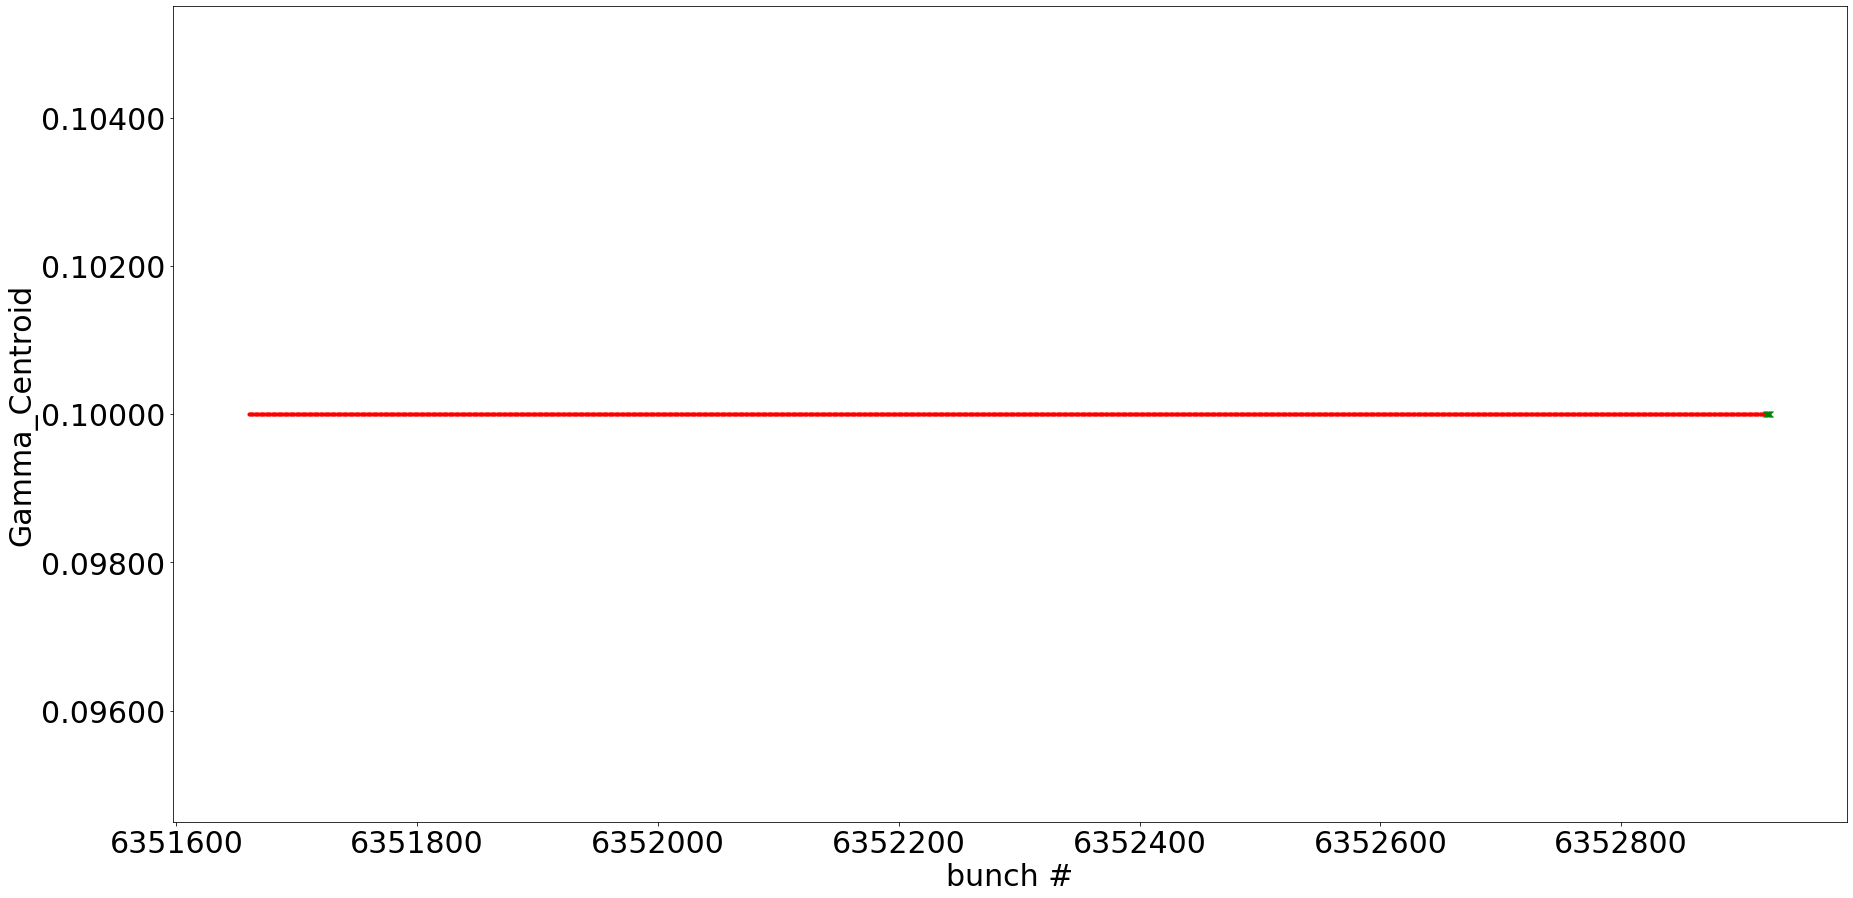

In [229]:
turn_display = 5041
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*1
rng3= rng2+5#nBunch*1
fig1,axes1 = plt.subplots(1,1)
axes1.plot(turns[rng1:rng2],np.array(M1_2[rng1:rng2]),'r.-')
axes1.plot(turns[rng2:rng3],np.array(M1_2[rng2:rng3]),'gx-')

fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.set_xlabel('bunch #',fontsize=30)
axes1.set_ylabel('Gamma_Centroid',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))
#fn_Ipeak = os.path.join(cwd,'Ipeak.jpg')
#plt.savefig(fn_Ipeak,bbox_inches='tight')
plt.show()

In [230]:
sin0 = np.sin(0*2*pi*f0*np.array(centroids))
cos0 = np.cos(0*2*pi*f0*np.array(centroids))
sin1 = np.sin(1*2*pi*f0*np.array(centroids))
cos1 = np.cos(1*2*pi*f0*np.array(centroids))
a0 = []
b0 = []
c0 = []
a1 = []
b1 = []
c1 = []
for i in range(nTurns):
    a0.append(np.sum(sin0*M1_2[i*nBunch:(i+1)*nBunch])/len(sin0))
    b0.append(np.sum(cos0*M1_2[i*nBunch:(i+1)*nBunch])/len(sin0))
    a1.append(np.sum(sin1*M1_2[i*nBunch:(i+1)*nBunch])/len(sin1))
    b1.append(np.sum(cos1*M1_2[i*nBunch:(i+1)*nBunch])/len(sin1))
c0 = np.array(a0)**2+np.array(b0)**2
c1 = np.array(a1)**2+np.array(b1)**2

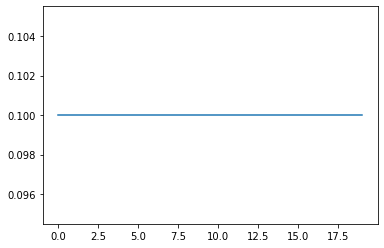

In [231]:
plt.plot(np.sqrt(c0)[5000:5020])

In [232]:
tau0 = T0/np.log(np.sqrt(c0)[5026]/np.sqrt(c0)[5025])
print(tau0)
print("OMEGA_Im : ",1/tau0)

inf
OMEGA_Im :  0.0


/home/txin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


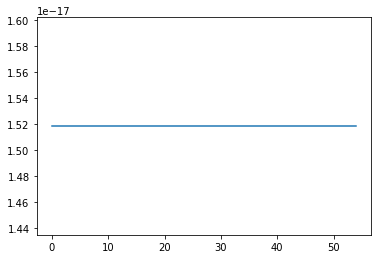

In [233]:
plt.plot(np.sqrt(c1)[5000:5055])

In [234]:
tau = 10*T0/np.log(np.sqrt(c1)[5030]/np.sqrt(c1)[5020])
print(tau)
print("OMEGA_Im : ",1/tau)

inf
OMEGA_Im :  0.0


/home/txin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [235]:
tau = 10*T0/np.log(np.sqrt(c1)[5035]/np.sqrt(c1)[5025])
print(tau*1e3,"ms")
print("OMEGA_Im : ",1/tau)

inf ms
OMEGA_Im :  0.0


/home/txin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [236]:
tau-1/(Qs*f0)*Ek_damp

inf

In [237]:
tau

inf

In [238]:
(Qs*f0)/Ek_damp

8.460567139038518e-06

In [239]:
1/(Qs*f0)*Ek_damp

118195.38614448521

In [240]:
# get info of all variables
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.5f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:20]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          test: 4.63214 GiB
                          time: 744.04916 MiB
                           Ibi: 744.04916 MiB
                          Ibi2: 744.04916 MiB
                        M1_all: 204.27712 MiB
                          M1_1: 98.40398 MiB
                          M1_2: 98.40398 MiB
                         turns: 96.13046 MiB
                     emittance: 984.46875 KiB
                            dt: 984.46875 KiB
                         gamma: 984.46875 KiB
             bucket_lower_lim3: 984.46875 KiB
             bucket_upper_lim3: 984.46875 KiB
                       dt_mask: 984.46875 KiB
                    gamma_mask: 984.46875 KiB
                           t_0: 984.46875 KiB
                       gamma_0: 984.46875 KiB
                     nPar_mask: 984.46875 KiB
                         sig_t: 984.46875 KiB
                     sig_gamma: 984.46875 KiB


In [116]:
# testing the formula for Ig with loading angle thetaL
thetaL = -20/180*pi
Phis = 81.88537662536568/180*pi
IbRF = IbDC*2
Vc = 1692857.1428571427
Rsh = 73*30533.268101761252

tgPhi = (1+IbRF*np.cos(Phis)/(Vc/Rsh))*np.tan(thetaL)+IbRF/(Vc/Rsh)*np.sin(Phis)

Ig = Vc/(Rsh)*np.cos(thetaL)*(1+np.tan(thetaL)*tgPhi)+IbRF*(np.cos(Phis)*np.cos(thetaL))*(1-np.tan(thetaL)*np.tan(Phis))
Ig_Gab = Vc/np.cos(thetaL)*(1+IbRF/(Vc/Rsh)*np.cos(Phis))/Rsh

print("Tan(Phi) = ",tgPhi)
print("Detune angle = ",np.arctan(tgPhi)/pi*180)
print("Ig magnitude = ",Ig)
print("Ig_Gab magnitude = ",Ig_Gab)


Tan(Phi) =  6.3379149062287095
Detune angle =  81.03375413314149
Ig magnitude =  1.6228321406590989
Ig_Gab magnitude =  1.6228321406590998


In [100]:
I_g

17.780006958816216

In [106]:
Vnew/Rsh/np.cos(thetaL)*(1+np.tan(thetaL)*tgPhi)+IbDC*2*(np.cos(PhisPhasorNew)*np.cos(thetaL))*(1-np.tan(thetaL)*np.tan(PhisPhasorNew))

1.0693114641756685

In [102]:
Vnew

1692857.1428571427

In [103]:
Vnew/Rsh/np.cos(thetaL)*(1+np.tan(thetaL)*tgPhi)

-1.4861803806568434

In [107]:
IbDC*2*(np.cos(PhisPhasorNew)*np.cos(thetaL))*(1-np.tan(thetaL)*np.tan(PhisPhasorNew))

2.555491844832512

In [109]:
PhisPhasorNew/pi*180

81.88537662536568

In [123]:
1/np.cos(15/180*pi)

1.035276180410083

In [132]:
frf = f0*h[0]
dphi = 2*pi*18.8e3*100*6/frf

In [140]:
dt = dphi/2/pi/frf
dt*1e9

0.03227700501278364

In [141]:
dt*3e8*100

0.9683101503835091